In [1]:
import os
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pandas.io.json import json_normalize
from tqdm import tqdm, tqdm_notebook
from random import randint

import pytz
import datetime
from datetime import datetime, timedelta
from geopy import geocoders
from tzwhere import tzwhere
from pytz import timezone
from time import sleep

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# set path
PATH = '../../data/ga_revenue/'
! pwd

/Users/zach-eberhart/Desktop/kaggle/notebooks/ga_revenue


# Feature Engineering

 - **TODO**:
     - look through categorical data and see if there are bins that can be created (ex: ad content)
     - mark the days that an advertising campaign begun (make sure to note which markets it appeared in)
         - maybe add a has_advertising_traffic col?
     - t-SNE cluster:
         - by row
         - by user
     - consider adding bins that have a better distribution (for economic data) rather than fixed width bins
         - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
     - consider using polynomial feature generator for all continuous features when finished generating them...
         - might be worth testing WITH or WITHOUT polynomial features

 - **DONE**:
     - pull in holiday data for each of the countries
         - Try scraping this API first: https://date.nager.at/Home/Api
         - if that doesn't work:
             - *this will be difficult to do for free, aggregate the amount of traffic by country and see if it's worth pulling in just US data (there are some datasets for US available for free)*.
             - list of some options:
                 - https://holidayapi.com
     - pull in avg internet speed for each of the countries
     - add a binary column that states whether or not there is a city, country mismatch... not sure how to do thia though... maybe lookup timezone for city and then lookup timezone for country and see if they match..? or lookup country for a city (new api?) and then see if that matches the country
     - see if there is a relationship between city/country and sales to try to determine which would be better to use for tz ID:
         - would be interesting to see how many records are affected by the city country mismatch
         - look specifically at developing nations, we would expect AVERAGE revenue/sales to be lower there
     - combining site data:
         - binary, has the visitor purchased anything before
         - binary, greater than one pageview
         - sum of pageviews per customer
         - sum of hits per customer
     - when grouping site data, consider grouping it (additionally) by country
         - might be worth using three different datasets:
             - group by metric type
             - group by metric type and country
             - group by metric type AND group by metric type and country
      - get a list of continuous cols with skewed distributions and apply a log transform to them
      
 - **REMOVED**:
     - pull in weather data for each of the countries
     - see if you can figure out when certain ad campaigns started, from there run the `add_elapsed()` function from Rossman
     - *High-cardinality*:
         - instead of using the feature as a cateory, calculate the number of times it appears in the dataset
         - try WOE or IV on high-cardinality features

 - **NOTES FOR TRAINING**:
     - Test whether or not the binned economic data is helpful or harmful in regards to model performance. Maybe test:
         - just cont
         - just cat
         - both

### Load Data

In [2]:
train_df = pd.read_feather(PATH+'feathers/train_processed_wdp_feather')
test_df = pd.read_feather(PATH+'feathers/test_processed_wdp_feather')
economic = pd.read_csv(PATH+'country_economic_and_tech.csv')

train_len = len(train_df)
test_len = len(test_df)

test_df['totals.transactionRevenue'] = 0
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

joined = deepcopy(train_df.append(test_df))

# sanity check
#joined.iloc[:train_len,:]['dataset'].value_counts()

del train_df, test_df

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Add Economic / Internet Usage Data

### Bin data to (maybe) account for missing

In [3]:
n_bins = 20
col_suffix = '_BIN%s' % n_bins

for col in [col for col in economic.columns if col != 'country']:
    new_col_name = str(col) + col_suffix
    economic[new_col_name] = pd.cut(economic[col], n_bins)

In [4]:
economic.head(3)

,country,netflix_internet_speed_index,mobile_subs_per_100,tel_subs_per_100,internet_usage_pct,broadband_subs_per_100,gdp_per_capita,gdp_per_capita_growth,high_tech_exports,netflix_internet_speed_index_BIN20,mobile_subs_per_100_BIN20,tel_subs_per_100_BIN20,internet_usage_pct_BIN20,broadband_subs_per_100_BIN20,gdp_per_capita_BIN20,gdp_per_capita_growth_BIN20,high_tech_exports_BIN20
0,Afghanistan,NaN,62.335417,0.329501,10.595726,0.025395,585.850064,0.071666,NaN,NaN,"(56.951, 72.531]","(-0.121, 6.049]","(6.03, 10.883]","(-0.0471, 2.419]","(69.536, 8632.873]","(-0.701, 2.501]",NaN
1,Albania,NaN,115.152265,8.496597,66.363445,9.102779,4537.862492,3.936913,8424644.0,NaN,"(103.69, 119.269]","(6.049, 12.098]","(64.268, 69.121]","(7.253, 9.671]","(69.536, 8632.873]","(2.501, 5.704]","(-1166780650.556, 58339034771.8]"
2,Algeria,NaN,115.848054,8.384733,42.945527,7.042219,4123.389937,-0.052730,4758110.0,NaN,"(103.69, 119.269]","(6.049, 12.098]","(40.002, 44.855]","(4.836, 7.253]","(69.536, 8632.873]","(-0.701, 2.501]","(-1166780650.556, 58339034771.8]"


### Merge with main dataset

In [5]:
joined.shape

(1708337, 47)

In [6]:
# add economic data to main df
economic = economic.rename(columns = {'country': 'geoNetwork.country'}).copy()
joined = joined.merge(economic, on = 'geoNetwork.country', how = 'left').copy()

### Fill NaNs

In [7]:
_cols = [c for c in economic.columns.tolist() if 'country' not in c]

In [8]:
# fill categorical nans with 'unknown' cat
for col in [col for col in _cols if 'BIN' in col]:
    joined[col] = joined[col].cat.add_categories('unknown').fillna('unknown')

# fill continuous nans with minimum less 50%
for c, m in joined[[col for col in _cols if 'BIN' not in col]].min().iteritems():
    if m > 0: m *= 0.5
    elif m < 0: m *=1.5
    else: pass
    
    joined[c] = joined[c].fillna(m).copy()

In [9]:
joined.head(3)

,channelGrouping,dataset,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,...,gdp_per_capita_growth,high_tech_exports,netflix_internet_speed_index_BIN20,mobile_subs_per_100_BIN20,tel_subs_per_100_BIN20,internet_usage_pct_BIN20,broadband_subs_per_100_BIN20,gdp_per_capita_BIN20,gdp_per_capita_growth_BIN20,high_tech_exports_BIN20
0,Organic Search,train,2016-09-02,Chrome,desktop,False,Windows,1131660440785968503,Izmir,Asia,...,5.778870,2.182767e+09,"(3.108, 3.258]","(88.11, 103.69]","(12.098, 18.147]","(54.562, 59.415]","(12.088, 14.506]","(8632.873, 17028.301]","(5.704, 8.907]","(-1166780650.556, 58339034771.8]"
1,Organic Search,train,2016-09-02,Firefox,desktop,False,Macintosh,377306020877927890,not available in demo dataset,Oceania,...,0.348880,4.572081e+09,"(3.108, 3.258]","(103.69, 119.269]","(30.244, 36.293]","(83.681, 88.534]","(29.01, 31.427]","(50610.015, 59005.444]","(-0.701, 2.501]","(-1166780650.556, 58339034771.8]"
2,Organic Search,train,2016-09-02,Chrome,desktop,False,Windows,3895546263509774583,Madrid,Europe,...,2.857074,1.420151e+10,"(3.258, 3.409]","(103.69, 119.269]","(42.342, 48.391]","(78.827, 83.681]","(29.01, 31.427]","(25423.73, 33819.158]","(2.501, 5.704]","(-1166780650.556, 58339034771.8]"


## Identify City / Country Mismatch

 - identify the mismatch in the data
     - then try to identify any particular instances when there is a mismatch (i.e. a certain date, device, from a specific traffic source / domain, etc)
     - check to see if any of the mismatches are driving revenue

In [17]:
# filter down to geo features
geos = joined[['geoNetwork.city', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.subContinent', 'geoNetwork.continent'] + 
              ['totals.hits', 'totals.pageviews', 'totals.transactionRevenue']
             ]

# replaces all NAs with uniform value
pd.options.mode.chained_assignment = None
for c in geos.columns:
    geos[c] = deepcopy(geos[c].apply(lambda x: 'UNKNOWN' if x == 'not available in demo dataset' else x))
    geos[c] = deepcopy(geos[c].apply(lambda x: 'UNKNOWN' if x == '(not set)' else x))
geos['totals.hits'] = geos['totals.hits'].fillna(0).astype(int).copy()

# print info on missing geos
for col in geos.columns:
    if 'geo' in col:
        print_label = '% Unknown {}:'.format(col.replace('geoNetwork.', ''))
        print(print_label, round(geos[col].value_counts()['UNKNOWN'] / len(geos) * 100, 3))

% Unknown city: 58.468
% Unknown country: 0.147
% Unknown metro: 77.26
% Unknown subContinent: 0.147
% Unknown continent: 0.147


In [35]:
# sort city/country combo by pageviews to make catching mismatches easier
geos['city_country'] = geos['geoNetwork.city'] + ', ' + geos['geoNetwork.country']
sorted_city_country = deepcopy(geos.iloc[:,-4:].groupby('city_country').sum().sort_values('totals.pageviews', ascending = False))
sorted_city_country['city_country'] = sorted_city_country.index
sorted_city_country.reset_index(drop = True, inplace = True)

# add to list (and strip whitespace) for easy parsing
full_city_list = [c.lower() for c in sorted_city_country.city_country.str.strip().drop_duplicates().tolist() if 'UNKNOWN' not in c]

In [96]:
# load in world city data
cities = pd.read_feather(PATH+'city_country_data/world_cities_merged')

# do another strip of whitespace and add city/country combo to a list
world_city_list = (cities['city'].str.strip() + ', ' + cities['country'].str.strip().apply(lambda x: x.lower())).tolist()

# check if each city in data is in the full world city list
potential_mismatch = [c for c in full_city_list if c not in world_city_list]

# manually exclude the incorrect mismatches
not_mismatch = [ 'quebec city, canada', 'zhongli district, taiwan', 'piscataway township, united states', 'chiyoda, japan', 'villafranca del castillo, spain', 'taoyuan district, taiwan', 'zhudong township, taiwan', 'oslo municipality, norway', 'new cairo city, egypt', 'mueang khon kaen district, thailand', 'minxiong township, taiwan', 'chiayi city, taiwan', 'mueang chiang mai district, thailand', 'dacun township, taiwan', 'amã, jordan', 'zhubei city, taiwan', 'kiryat ono, israel', 'dalat, vietnam', 'neipu township, taiwan', 'guishan district, taiwan', 'hukou township, taiwan', 'toufen city, taiwan', 'zaoqiao township, taiwan', 'longtan district, taiwan', 'pingtung city, taiwan']
mismatch = [c for c in potential_mismatch if c not in not_mismatch]

# print the percentage of records affected
geos['city_country'] = geos['city_country'].str.lower().copy()
print('% city/country mismatch:', (len(geos[geos['city_country'].isin(mismatch)]) / len(joined)) * 100)

# add to full dataset
joined['city_country_mismatch'] = geos['city_country'].isin(mismatch).copy()

% city/country mismatch: 0.20066298394286375


### Export to feather

In [112]:
# # temp conversion of economic bin cols to str for feather export
# for cat_col in [c for c in joined.columns if 'BIN' in c]:
#     joined[cat_col] = joined[cat_col].astype(str).copy()

# joined.to_feather(PATH+'feathers/joined_processed_wdp_ccmismatch_feather')

## Add Holiday Data

In [3]:
joined = pd.read_feather(PATH+'feathers/joined_processed_wdp_ccmismatch_feather')

In [4]:
joined.shape

(1708337, 64)

In [259]:
# get unique list of countries from data
countries = [c.lower() for c in joined['geoNetwork.country'].drop_duplicates().tolist()]
countries = pd.DataFrame({'country': countries})

# pull in country codes from world cities file
wcl = pd.read_feather(PATH+'city_country_data/world_cities_merged')
wcl = wcl.drop('city', 1).drop_duplicates().reset_index(drop = True).copy()

# merge
countries = countries.merge(wcl, on = 'country', how = 'left').copy()
countries.dropna(inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [260]:
joined['visitStartTimeLOCALYear'].value_counts()

2017    928785
2016    436199
2018    343353
Name: visitStartTimeLOCALYear, dtype: int64

In [397]:
years = joined['visitStartTimeLOCALYear'].drop_duplicates().tolist()

# get the months in 2018 which had data for Holiday API (error on future holidays)
months_2018 = ['0' + str(m) for m in
               joined[joined['visitStartTimeLOCALYear'] == 2018]['visitStartTimeLOCALMonth'].drop_duplicates().sort_values().tolist()
              ]

months_2018

['01', '02', '03', '04', '05']

In [398]:
# add additional months for accurate calc of 'days before holiday'
months_2018 += ['06', '07', '08']

### Use Holiday API to get holidays for each country

In [400]:
def get_holidays_by_country(df, sleep_duration = 0.25):

    country_holidays = {}

    for country, country_code in zip(df['country'].tolist(), df['code'].tolist()):
        
        _year = {}
        
        for year in years:

            print('Starting:', country)

            try:
                call_str = 'http://date.nager.at/api/v1/get/%s/%s' % (country_code.upper(), year)
                r = requests.get(call_str)
                holiday_dates = deepcopy(pd.DataFrame(json.loads(r.text))['date'].tolist())
                _year[year] = holiday_dates

            except:
                _year[year] = []

            sleep(sleep_duration)
        
        country_holidays[country] = _year
    
    return country_holidays

# flatten parsed json data
def flatten_holiday_data(parsed_holiday_data):

    full_country_holidays = {}

    for country, years in parsed_holiday_data.items():
        agg_holiday_dates = []
        for year, dates in years.items():
            agg_holiday_dates += dates

        if len(agg_holiday_dates) > 0:
            full_country_holidays[country] = agg_holiday_dates
    
    return full_country_holidays

In [274]:
# get holidays by country
country_holidays = get_holidays_by_country(countries)

# list which countries are missing holidays
countries_missing_holidays = [c for c in countries.country.tolist() if c not in list(flatten_holiday_data(country_holidays).keys())]

# run through the list again with a longer sleep between calls
country_holidays_again = get_holidays_by_country(countries, sleep_duration = 1)

# check if the two holiday lists are the same
[c for c in countries.country.tolist() if c not in list(flatten_holiday_data(country_holidays_again).keys())] == countries_missing_holidays

True

### Check the other API, "Holiday API"

In [401]:
def get_holidays_by_country_2(country_dict, sleep_duration = 0.25):

    country_holidays = {}
    base_call_str = 'https://holidayapi.com/v1/holidays?key=7736afdc-dc1c-4cab-b94a-3a0a13cf7ee7&'

    for country, country_code in country_dict.items():
        
        _year = {}
        
        for year in years:

            print('Starting:', country)

            if int(year) < 2018:
                call_str = base_call_str + 'country=%s&year=%s' % (country_code, year)
                r = requests.get(call_str)
                json_response = deepcopy(json.loads(r.text)['holidays'])
                holiday_dates = list(json_response.keys())
                
                _year[year] = holiday_dates
                sleep(sleep_duration)
            
            else:
                for month in months_2018:
                    call_str = base_call_str + 'country=%s&year=%s&month=%s' % (country_code, year, month)
                    r = requests.get(call_str)
                    json_response = deepcopy(json.loads(r.text)['holidays'])
                    if type(json_response) == list:
                        if len(json_response) > 0: holiday_dates = [json_response[0]['date']]
                        else: pass
                    else:
                        holiday_dates = list(json_response.keys())
                    
                    _year[str(year) + '_' + str(month)] = holiday_dates
                    sleep(sleep_duration)
            
        country_holidays[country] = _year
    
    return country_holidays

In [277]:
supported_countries = [cc.lower() for cc in ['AO', 'AT', 'AU', 'AW', 'AX', 'BA', 'BE', 'BG', 'BO', 'BR', 'BS', 'CA', 'CH', 'CN', 'CO', 'CR', 'CU', 'CZ', 'DE', 'DK', 'DO', 'EC', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IN', 'IL', 'IS', 'IT', 'JP', 'KZ', 'LS', 'LU', 'MG', 'MQ', 'MT', 'MU', 'MX', 'MZ', 'NG', 'NL', 'NO', 'PE', 'PK', 'PH', 'PL', 'PR', 'PT', 'PY', 'RE', 'RO', 'RU', 'SC', 'SE', 'SG', 'SI', 'ST', 'SK', 'TN', 'TR', 'UA', 'US', 'UY', 'VE', 'ZA', 'ZW']]
#[c for c in countries_missing_holidays if c in wcl[wcl['code'].isin(supported_countries)].country.tolist()]

In [402]:
missing_countries_for_holidayapi = {
    
    'indonesia': 'ID',
    'pakistan': 'PK',
    'india': 'IN',
    'singapore': 'SG',
    'nigeria': 'NG',
    'philippines': 'PH',
    'japan': 'JP',
    'hong kong': 'HK',
    'israel': 'IL',
    'bosnia & herzegovina': 'BA',
    'kazakhstan': 'KZ',
    'zimbabwe': 'ZW',
    'mauritius': 'MU',
    'angola': 'AO',
    'martinique': 'MQ',
    'aruba': 'AW',
    'seychelles': 'SC',
    'são tomé & príncipe': 'ST'

}

In [404]:
holidays_for_missing_countries = get_holidays_by_country_2(missing_countries_for_holidayapi, sleep_duration = 0.5)

### Merge data from the two APIs

In [406]:
full_country_holidays = {**flatten_holiday_data(country_holidays),
                         **flatten_holiday_data(holidays_for_missing_countries)
                        }

In [283]:
print('% of Countries with Holiday Data:', round(len(list(full_country_holidays.keys())) / len(countries.country.tolist())*100, 4))

% of Countries with Holiday Data: 47.5336


## Add Holiday Data to Dataset
 - cat: is holiday, is not holiday, unknown (holiday data not found)
 - days before holiday
 - days after holiday

In [294]:
# check if there are any countries that are not in the data
[c for c in list(full_country_holidays.keys()) if c not in joined['geoNetwork.country'].drop_duplicates().str.lower().tolist()]

[]

In [339]:
# create temp df to pull in holiday data
tdf = pd.DataFrame(joined['visitStartTimeLOCAL'].apply(lambda x: x.strftime('%Y-%m-%d')))
tdf['country'] = joined['geoNetwork.country'].str.lower().copy()
tdf.columns = ['str_date', 'country']

# create a list of countries we have holidays for
countries_with_holidays = list(full_country_holidays.keys())

# bool for all days that are holidays, by country
def mark_holiday_by_country(row):
    if row['country'] in countries_with_holidays:
        if row['str_date'] in full_country_holidays[row['country']]:
            return 'yes'
        else: return 'no'
    return 'unknown'

tdf['is_holiday'] = tdf.apply(mark_holiday_by_country, 1)

In [341]:
tdf['is_holiday'].value_counts() / len(joined)

no         0.879305
unknown    0.095105
yes        0.025589
Name: is_holiday, dtype: float64

In [ ]:
# add to main dataset
joined['is_holiday'] = deepcopy(tdf['is_holiday'])

### Add "Days Before" and "Days After" Holiday cols

In [358]:
# convert holiday dates to dt
full_country_holidays_dt = {}

for country in list(full_country_holidays.keys()):
    holiday_dates = full_country_holidays[country]
    holiday_dates_dt = [pd.to_datetime(d) for d in holiday_dates]
    full_country_holidays_dt[country] = deepcopy(holiday_dates_dt)

In [449]:
def days_before_holiday(row):
    if row['is_holiday'] != 'unknown':
        if row['is_holiday'] == 'yes':
            return 0
        current_date = pd.to_datetime(row['str_date'])
        holiday_dates = np.array(full_country_holidays_dt[row['country']])
        holiday_timedelta = (holiday_dates - current_date).astype('timedelta64[D]').astype('int')
        return holiday_timedelta[holiday_timedelta > 0].min()

def days_after_holiday(row):
    if row['is_holiday'] != 'unknown':
        if row['is_holiday'] == 'yes':
            return 0
        current_date = pd.to_datetime(row['str_date'])
        holiday_dates = np.array(full_country_holidays_dt[row['country']])
        holiday_timedelta = (holiday_dates - current_date).astype('timedelta64[D]').astype('int')
        return abs(holiday_timedelta[holiday_timedelta < 0]).min()

# calc days before and after holiday
tdf['days_after_holiday'] = tdf.apply(days_after_holiday, 1)
tdf['days_before_holiday'] = tdf.apply(days_before_holiday, 1)

In [456]:
tdf.head()

,str_date,country,is_holiday,days_after_holiday,days_before_holiday
0,2016-09-02,turkey,no,3.0,57.0
1,2016-09-03,australia,no,33.0,113.0
2,2016-09-03,spain,no,1.0,5.0
3,2016-09-03,indonesia,no,17.0,113.0
4,2016-09-02,united kingdom,no,4.0,89.0


In [457]:
# add holiday info to primary dataset
joined['days_after_holiday'] = deepcopy(tdf['days_after_holiday'])
joined['days_before_holiday'] = deepcopy(tdf['days_before_holiday'])

# two more calc features for holidays
joined['holiday_anticipation'] = joined['days_after_holiday'] / joined['days_before_holiday']
joined['holiday_gap'] = joined['days_after_holiday'] + joined['days_before_holiday']

### Export to Feather

In [463]:
# joined.to_feather(PATH+'feathers/joined_processed_wdp_ccmismatch_holidays_feather')

## Group Site Data

In [3]:
joined = pd.read_feather(PATH+'feathers/joined_processed_wdp_ccmismatch_holidays_feather')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [3]:
joined.head()

,channelGrouping,dataset,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,...,broadband_subs_per_100_BIN20,gdp_per_capita_BIN20,gdp_per_capita_growth_BIN20,high_tech_exports_BIN20,city_country_mismatch,is_holiday,days_after_holiday,days_before_holiday,holiday_anticipation,holiday_gap
0,Organic Search,train,2016-09-02,Chrome,desktop,False,Windows,1131660440785968503,Izmir,Asia,...,"(12.088, 14.506]","(8632.873, 17028.301]","(5.704, 8.907]","(-1166780650.556, 58339034771.8]",False,no,3.0,57.0,0.052632,60.0
1,Organic Search,train,2016-09-02,Firefox,desktop,False,Macintosh,377306020877927890,not available in demo dataset,Oceania,...,"(29.01, 31.427]","(50610.015, 59005.444]","(-0.701, 2.501]","(-1166780650.556, 58339034771.8]",False,no,33.0,113.0,0.292035,146.0
2,Organic Search,train,2016-09-02,Chrome,desktop,False,Windows,3895546263509774583,Madrid,Europe,...,"(29.01, 31.427]","(25423.73, 33819.158]","(2.501, 5.704]","(-1166780650.556, 58339034771.8]",False,no,1.0,5.0,0.200000,6.0
3,Organic Search,train,2016-09-02,UC Browser,desktop,False,Linux,4763447161404445595,not available in demo dataset,Asia,...,"(-0.0471, 2.419]","(69.536, 8632.873]","(2.501, 5.704]","(-1166780650.556, 58339034771.8]",False,no,17.0,113.0,0.150442,130.0
4,Organic Search,train,2016-09-02,Chrome,mobile,True,Android,27294437909732085,not available in demo dataset,Europe,...,"(36.262, 38.68]","(33819.158, 42214.587]","(-0.701, 2.501]","(58339034771.8, 116678069499.6]",False,no,4.0,89.0,0.044944,93.0


In [4]:
cat_vars = [

    'channelGrouping', 'visitNumber',

    'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',

    'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
    'geoNetwork.region', 'geoNetwork.subContinent',

    'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
    'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source',

    'visitStartTimeLOCALYear', 'visitStartTimeLOCALMonth', 'visitStartTimeLOCALWeek',
    'visitStartTimeLOCALDay', 'visitStartTimeLOCALDayofweek', 'visitStartTimeLOCALDayofyear', 'visitStartTimeLOCALIs_month_end',
    'visitStartTimeLOCALIs_month_start', 'visitStartTimeLOCALIs_quarter_end', 'visitStartTimeLOCALIs_quarter_start',
    'visitStartTimeLOCALIs_year_end', 'visitStartTimeLOCALIs_year_start', 'visitStartTimeLOCALHourofday'
]

contin_vars = [
    'totals.hits',
    'totals.pageviews'
    #'visitNumber'      <-- CONSIDER ADDING VISIT NUMBER AS A CONTINUOUS VARIABLE (AS WELL, OR ONLY?)
]

### Time Based

In [15]:
# init a new df for all grouped features
df = pd.DataFrame()
df['fullVisitorId'] = joined['fullVisitorId'].copy()

# add temp str date cols for unique visitor count
df['TEMP_year'] = joined['visitStartTimeLOCAL'].apply(lambda x: x.strftime('%Y'))
df['TEMP_year_month'] = joined['visitStartTimeLOCAL'].apply(lambda x: x.strftime('%Y-%m'))
df['TEMP_ymd'] = joined['visitStartTimeLOCAL'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['TEMP_ymdh'] = joined['visitStartTimeLOCAL'].apply(lambda x: x.strftime('%Y-%m-%d-%H'))

# add other date parts
df['TEMP_day_of_week'] = joined['visitStartTimeLOCALDayofweek'].copy()
df['TEMP_week_of_year'] = joined['visitStartTimeLOCALWeek'].copy()
df['TEMP_hour_of_day'] = joined['visitStartTimeLOCALHourofday'].copy()
df['TEMP_day_of_year'] = joined['visitStartTimeLOCALDayofyear'].copy()
df['TEMP_month_of_year'] = joined['visitStartTimeLOCALMonth'].copy()
df['TEMP_ym_dow'] = df['TEMP_year_month'].astype(str) + '-' + df['TEMP_day_of_week'].astype(str)
df['TEMP_year_woy'] = df['TEMP_year'].astype(str) + '-' + df['TEMP_week_of_year'].astype(str)

# unique visitor count by date grouping
df['year_uv_count'] = df.groupby('TEMP_year')['fullVisitorId'].transform('nunique').copy()
df['ym_uv_count'] = df.groupby('TEMP_year_month')['fullVisitorId'].transform('nunique').copy()
df['ymd_uv_count'] = df.groupby('TEMP_ymd')['fullVisitorId'].transform('nunique').copy()
df['ymdh_uv_count'] = df.groupby('TEMP_ymdh')['fullVisitorId'].transform('nunique').copy()
df['dow_uv_count'] = df.groupby('TEMP_ym_dow')['fullVisitorId'].transform('nunique').copy()
df['woy_uv_count'] = df.groupby('TEMP_year_woy')['fullVisitorId'].transform('nunique').copy()

# fill incomplete years with avg monthly by year
df.loc[df['TEMP_year'] == '2016', 'year_uv_count'] = 354644 * (12/6) 
df.loc[df['TEMP_year'] == '2018', 'year_uv_count'] = 266646 * (12/5)

# fill incomplete months with avail year's ym data
df.loc[df['TEMP_year_month'] == '2016-07', 'ym_uv_count'] = 58606
df.loc[df['TEMP_year_month'] == '2018-05', 'ym_uv_count'] = 52256

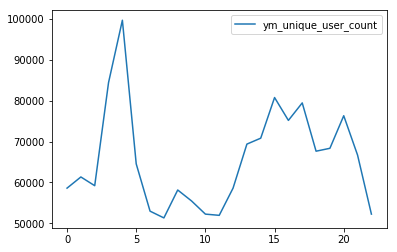

In [86]:
df[['TEMP_year_month', 'ym_unique_user_count']].drop_duplicates().sort_values('TEMP_year_month').reset_index(drop = True).plot();

In [106]:
# add some site metrics
df['pageviews'] = joined['totals.pageviews'].copy().astype(int)
df['hits'] = joined['totals.hits'].copy().astype(int)
df['visit_number'] = joined['visitNumber'].copy()
df['return_visit'] = df['visitNumber'] > 1

# total pageviews by date grouping
df['year_total_pageviews'] = df.groupby('TEMP_year')['pageviews'].transform('sum').copy()
df['ym_total_pageviews'] = df.groupby('TEMP_year_month')['pageviews'].transform('sum').copy()
df['ymd_total_pageviews'] = df.groupby('TEMP_ymd')['pageviews'].transform('sum').copy()
df['ymdh_total_pageviews'] = df.groupby('TEMP_ymdh')['pageviews'].transform('sum').copy()
df['dow_total_pageviews'] = df.groupby('TEMP_ym_dow')['pageviews'].transform('sum').copy()
df['woy_total_pageviews'] = df.groupby('TEMP_year_woy')['pageviews'].transform('sum').copy()

# total hits by date grouping
df['year_total_hits'] = df.groupby('TEMP_year')['hits'].transform('sum').copy()
df['ym_total_hits'] = df.groupby('TEMP_year_month')['hits'].transform('sum').copy()
df['ymd_total_hits'] = df.groupby('TEMP_ymd')['hits'].transform('sum').copy()
df['ymdh_total_hits'] = df.groupby('TEMP_ymdh')['hits'].transform('sum').copy()
df['dow_total_hits'] = df.groupby('TEMP_ym_dow')['hits'].transform('sum').copy()
df['woy_total_hits'] = df.groupby('TEMP_year_woy')['hits'].transform('sum').copy()

# total return visits by date grouping
df['year_total_return_visit'] = df.groupby('TEMP_year')['return_visit'].transform('sum').copy()
df['ym_total_return_visit'] = df.groupby('TEMP_year_month')['return_visit'].transform('sum').copy()
df['ymd_total_return_visit'] = df.groupby('TEMP_ymd')['return_visit'].transform('sum').copy()
df['ymdh_total_return_visit'] = df.groupby('TEMP_ymdh')['return_visit'].transform('sum').copy()
df['dow_total_return_visit'] = df.groupby('TEMP_ym_dow')['return_visit'].transform('sum').copy()
df['woy_total_return_visit'] = df.groupby('TEMP_year_woy')['return_visit'].transform('sum').copy()

# avg pageviews by date grouping
df['year_avg_pageviews'] = df.groupby('TEMP_year')['pageviews'].transform('mean').copy()
df['ym_avg_pageviews'] = df.groupby('TEMP_year_month')['pageviews'].transform('mean').copy()
df['ymd_avg_pageviews'] = df.groupby('TEMP_ymd')['pageviews'].transform('mean').copy()
df['ymdh_avg_pageviews'] = df.groupby('TEMP_ymdh')['pageviews'].transform('mean').copy()
df['dow_avg_pageviews'] = df.groupby('TEMP_ym_dow')['pageviews'].transform('mean').copy()
df['woy_avg_pageviews'] = df.groupby('TEMP_year_woy')['pageviews'].transform('mean').copy()

# avg hits by date grouping
df['year_avg_hits'] = df.groupby('TEMP_year')['hits'].transform('mean').copy()
df['ym_avg_hits'] = df.groupby('TEMP_year_month')['hits'].transform('mean').copy()
df['ymd_avg_hits'] = df.groupby('TEMP_ymd')['hits'].transform('mean').copy()
df['ymdh_avg_hits'] = df.groupby('TEMP_ymdh')['hits'].transform('mean').copy()
df['dow_avg_hits'] = df.groupby('TEMP_ym_dow')['hits'].transform('mean').copy()
df['woy_avg_hits'] = df.groupby('TEMP_year_woy')['hits'].transform('mean').copy()

# avg return visits by date grouping
df['year_avg_return_visit'] = df.groupby('TEMP_year')['return_visit'].transform('mean').copy()
df['ym_avg_return_visit'] = df.groupby('TEMP_year_month')['return_visit'].transform('mean').copy()
df['ymd_avg_return_visit'] = df.groupby('TEMP_ymd')['return_visit'].transform('mean').copy()
df['ymdh_avg_return_visit'] = df.groupby('TEMP_ymdh')['return_visit'].transform('mean').copy()
df['dow_avg_return_visit'] = df.groupby('TEMP_ym_dow')['return_visit'].transform('mean').copy()
df['woy_avg_return_visit'] = df.groupby('TEMP_year_woy')['return_visit'].transform('mean').copy()

# avg pageviews/hits
df['year_avg_pvph'] = df['year_total_pageviews'] / df['year_total_hits']
df['ym_avg_pvph'] = df['ym_total_pageviews'] / df['ym_total_hits']
df['ymd_avg_pvph'] = df['ymd_total_pageviews'] / df['ymd_total_hits']
df['ymdh_avg_pvph'] = df['ymdh_total_pageviews'] / df['ymdh_total_hits']
df['dow_avg_pvph'] = df['dow_total_pageviews'] / df['dow_total_hits']
df['woy_avg_pvph'] = df['woy_total_pageviews'] / df['woy_total_hits']

# avg pageviews per unique visitor
df['year_avg_pvpuv'] = df['year_total_pageviews'] / df['year_uv_count']
df['ym_avg_pvpuv'] = df['ym_total_pageviews'] / df['ym_uv_count']
df['ymd_avg_pvpuv'] = df['ymd_total_pageviews'] / df['ymd_uv_count']
df['ymdh_avg_pvpuv'] = df['ymdh_total_pageviews'] / df['ymdh_uv_count']
df['dow_avg_pvpuv'] = df['dow_total_pageviews'] / df['dow_uv_count']
df['woy_avg_pvpuv'] = df['woy_total_pageviews'] / df['woy_uv_count']

# avg return visits per unique visitor
df['year_avg_rvpuv'] = df['year_total_return_visit'] / df['year_uv_count']
df['ym_avg_rvpuv'] = df['ym_total_return_visit'] / df['ym_uv_count']
df['ymd_avg_rvpuv'] = df['ymd_total_return_visit'] / df['ymd_uv_count']
df['ymdh_avg_rvpuv'] = df['ymdh_total_return_visit'] / df['ymdh_uv_count']
df['dow_avg_rvpuv'] = df['dow_total_return_visit'] / df['dow_uv_count']
df['woy_avg_rvpuv'] = df['woy_total_return_visit'] / df['woy_uv_count']

# avg return visits / total pageviews
df['year_avg_rvbtv'] = df['year_total_return_visit'] / df['year_total_pageviews']
df['ym_avg_rvbtv'] = df['ym_total_return_visit'] / df['ym_total_pageviews']
df['ymd_avg_rvbtv'] = df['ymd_total_return_visit'] / df['ymd_total_pageviews']
df['ymdh_avg_rvbtv'] = df['ymdh_total_return_visit'] / df['ymdh_total_pageviews']
df['dow_avg_rvbtv'] = df['dow_total_return_visit'] / df['dow_total_pageviews']
df['woy_avg_rvbtv'] = df['woy_total_return_visit'] / df['woy_total_pageviews']

### Additional "Overall" Time-based

In [330]:
# calc unique visitors by device grouping
df['overall_dow_uv_count'] = df.groupby('TEMP_day_of_week')['fullVisitorId'].transform('nunique').copy()
df['overall_woy_uv_count'] = df.groupby('TEMP_week_of_year')['fullVisitorId'].transform('nunique').copy()
df['overall_hod_uv_count'] = df.groupby('TEMP_hour_of_day')['fullVisitorId'].transform('nunique').copy()
df['overall_doy_uv_count'] = df.groupby('TEMP_day_of_year')['fullVisitorId'].transform('nunique').copy()
df['overall_moy_uv_count'] = df.groupby('TEMP_month_of_year')['fullVisitorId'].transform('nunique').copy()

# total pageviews by device grouping
df['overall_dow_total_pageviews'] = df.groupby('TEMP_day_of_week')['pageviews'].transform('sum').copy()
df['overall_woy_total_pageviews'] = df.groupby('TEMP_week_of_year')['pageviews'].transform('sum').copy()
df['overall_hod_total_pageviews'] = df.groupby('TEMP_hour_of_day')['pageviews'].transform('sum').copy()
df['overall_doy_total_pageviews'] = df.groupby('TEMP_day_of_year')['pageviews'].transform('sum').copy()
df['overall_moy_total_pageviews'] = df.groupby('TEMP_month_of_year')['pageviews'].transform('sum').copy()

# total pageviews by device grouping
df['overall_dow_total_hits'] = df.groupby('TEMP_day_of_week')['hits'].transform('sum').copy()
df['overall_woy_total_hits'] = df.groupby('TEMP_week_of_year')['hits'].transform('sum').copy()
df['overall_hod_total_hits'] = df.groupby('TEMP_hour_of_day')['hits'].transform('sum').copy()
df['overall_doy_total_hits'] = df.groupby('TEMP_day_of_year')['hits'].transform('sum').copy()
df['overall_moy_total_hits'] = df.groupby('TEMP_month_of_year')['hits'].transform('sum').copy()

# total return visits by device grouping
df['overall_dow_total_return_visit'] = df.groupby('TEMP_day_of_week')['return_visit'].transform('sum').copy()
df['overall_woy_total_return_visit'] = df.groupby('TEMP_week_of_year')['return_visit'].transform('sum').copy()
df['overall_hod_total_return_visit'] = df.groupby('TEMP_hour_of_day')['return_visit'].transform('sum').copy()
df['overall_doy_total_return_visit'] = df.groupby('TEMP_day_of_year')['return_visit'].transform('sum').copy()
df['overall_moy_total_return_visit'] = df.groupby('TEMP_month_of_year')['return_visit'].transform('sum').copy()

# avg pageviews by device grouping
df['overall_dow_avg_pageviews'] = df.groupby('TEMP_day_of_week')['pageviews'].transform('mean').copy()
df['overall_woy_avg_pageviews'] = df.groupby('TEMP_week_of_year')['pageviews'].transform('mean').copy()
df['overall_hod_avg_pageviews'] = df.groupby('TEMP_hour_of_day')['pageviews'].transform('mean').copy()
df['overall_doy_avg_pageviews'] = df.groupby('TEMP_day_of_year')['pageviews'].transform('mean').copy()
df['overall_moy_avg_pageviews'] = df.groupby('TEMP_month_of_year')['pageviews'].transform('mean').copy()

# avg hits by device grouping
df['overall_dow_avg_hits'] = df.groupby('TEMP_day_of_week')['hits'].transform('mean').copy()
df['overall_woy_avg_hits'] = df.groupby('TEMP_week_of_year')['hits'].transform('mean').copy()
df['overall_hod_avg_hits'] = df.groupby('TEMP_hour_of_day')['hits'].transform('mean').copy()
df['overall_doy_avg_hits'] = df.groupby('TEMP_day_of_year')['hits'].transform('mean').copy()
df['overall_moy_avg_hits'] = df.groupby('TEMP_month_of_year')['hits'].transform('mean').copy()

# avg return visits by device grouping
df['overall_dow_avg_return_visit'] = df.groupby('TEMP_day_of_week')['return_visit'].transform('mean').copy()
df['overall_woy_avg_return_visit'] = df.groupby('TEMP_week_of_year')['return_visit'].transform('mean').copy()
df['overall_hod_avg_return_visit'] = df.groupby('TEMP_hour_of_day')['return_visit'].transform('mean').copy()
df['overall_doy_avg_return_visit'] = df.groupby('TEMP_day_of_year')['return_visit'].transform('mean').copy()
df['overall_moy_avg_return_visit'] = df.groupby('TEMP_month_of_year')['return_visit'].transform('mean').copy()

# avg pageviews per hit
df['overall_dow_avg_pvph'] = df['overall_dow_total_pageviews'] / df['overall_dow_total_hits']
df['overall_woy_avg_pvph'] = df['overall_woy_total_pageviews'] / df['overall_woy_total_hits']
df['overall_hod_avg_pvph'] = df['overall_hod_total_pageviews'] / df['overall_hod_total_hits']
df['overall_doy_avg_pvph'] = df['overall_doy_total_pageviews'] / df['overall_doy_total_hits']
df['overall_moy_avg_pvph'] = df['overall_moy_total_pageviews'] / df['overall_moy_total_hits']

# avg pageviews per unique visitor
df['overall_dow_avg_pvpuv'] = df['overall_dow_total_pageviews'] / df['overall_dow_uv_count']
df['overall_woy_avg_pvpuv'] = df['overall_woy_total_pageviews'] / df['overall_woy_uv_count']
df['overall_hod_avg_pvpuv'] = df['overall_hod_total_pageviews'] / df['overall_hod_uv_count']
df['overall_doy_avg_pvpuv'] = df['overall_doy_total_pageviews'] / df['overall_doy_uv_count']
df['overall_moy_avg_pvpuv'] = df['overall_moy_total_pageviews'] / df['overall_moy_uv_count']

# avg return visits per unique visitor
df['overall_dow_avg_rvpuv'] = df['overall_dow_total_return_visit'] / df['overall_dow_uv_count']
df['overall_woy_avg_rvpuv'] = df['overall_woy_total_return_visit'] / df['overall_woy_uv_count']
df['overall_hod_avg_rvpuv'] = df['overall_hod_total_return_visit'] / df['overall_hod_uv_count']
df['overall_doy_avg_rvpuv'] = df['overall_doy_total_return_visit'] / df['overall_doy_uv_count']
df['overall_moy_avg_rvpuv'] = df['overall_moy_total_return_visit'] / df['overall_moy_uv_count']

# avg return visits / total pageviews
df['overall_dow_avg_rvbtv'] = df['overall_dow_total_return_visit'] / df['overall_dow_total_pageviews']
df['overall_woy_avg_rvbtv'] = df['overall_woy_total_return_visit'] / df['overall_woy_total_pageviews']
df['overall_hod_avg_rvbtv'] = df['overall_hod_total_return_visit'] / df['overall_hod_total_pageviews']
df['overall_doy_avg_rvbtv'] = df['overall_doy_total_return_visit'] / df['overall_doy_total_pageviews']
df['overall_moy_avg_rvbtv'] = df['overall_moy_total_return_visit'] / df['overall_moy_total_pageviews']

In [135]:
df.head()

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,year_unique_user_count,...,ymd_avg_rvbtv,ymdh_avg_rvbtv,dow_avg_rvbtv,woy_avg_rvbtv,browser_os,browser_device,os_device,TEMP_browser,TEMP_device,TEMP_os
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,709288.0,...,0.047431,0.045131,0.048598,0.045033,Chrome_Windows,Chrome_desktop,Windows_Chrome,Chrome,desktop,Windows
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,709288.0,...,0.038036,0.021459,0.038979,0.045033,Firefox_Macintosh,Firefox_desktop,Macintosh_Firefox,Firefox,desktop,Macintosh
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,709288.0,...,0.038036,0.061404,0.038979,0.045033,Chrome_Windows,Chrome_desktop,Windows_Chrome,Chrome,desktop,Windows
3,4763447161404445595,2016,2016-09,2016-09-03,2016-09-03-13,5,35,2016-09-5,2016-35,709288.0,...,0.038036,0.065375,0.038979,0.045033,UC Browser_Linux,UC Browser_desktop,Linux_UC Browser,UC Browser,desktop,Linux
4,27294437909732085,2016,2016-09,2016-09-02,2016-09-02-13,4,35,2016-09-4,2016-35,709288.0,...,0.047431,0.043282,0.048598,0.045033,Chrome_Android,Chrome_mobile,Android_Chrome,Chrome,mobile,Android


### Device Based

In [138]:
joined[['device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem']].head(5)

,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem
0,Chrome,desktop,False,Windows
1,Firefox,desktop,False,Macintosh
2,Chrome,desktop,False,Windows
3,UC Browser,desktop,False,Linux
4,Chrome,mobile,True,Android


In [136]:
# pull in device cols from main dataset
df['TEMP_browser'] = joined['device.browser'].copy()
df['TEMP_device'] = joined['device.deviceCategory'].copy()
df['TEMP_os'] = joined['device.operatingSystem'].copy()
df['browser_device'] = joined['device.browser'] + '_' + joined['device.deviceCategory']
df['browser_os'] = joined['device.browser'] + '_' + joined['device.operatingSystem']
df['os_device'] = joined['device.operatingSystem'] + '_' + joined['device.deviceCategory']

# calc unique visitors by device grouping
df['browser_uv_count'] = df.groupby('TEMP_browser')['fullVisitorId'].transform('nunique').copy()
df['device_uv_count'] = df.groupby('TEMP_device')['fullVisitorId'].transform('nunique').copy()
df['os_uv_count'] = df.groupby('TEMP_os')['fullVisitorId'].transform('nunique').copy()
df['browser_device_uv_count'] = df.groupby('browser_device')['fullVisitorId'].transform('nunique').copy()
df['browser_os_uv_count'] = df.groupby('browser_os')['fullVisitorId'].transform('nunique').copy()
df['os_device_uv_count'] = df.groupby('os_device')['fullVisitorId'].transform('nunique').copy()

# total pageviews by device grouping
df['browser_total_pageviews'] = df.groupby('TEMP_browser')['pageviews'].transform('sum').copy()
df['device_total_pageviews'] = df.groupby('TEMP_device')['pageviews'].transform('sum').copy()
df['os_total_pageviews'] = df.groupby('TEMP_os')['pageviews'].transform('sum').copy()
df['browser_device_total_pageviews'] = df.groupby('browser_device')['pageviews'].transform('sum').copy()
df['browser_os_total_pageviews'] = df.groupby('browser_os')['pageviews'].transform('sum').copy()
df['os_device_total_pageviews'] = df.groupby('os_device')['pageviews'].transform('sum').copy()

# total pageviews by device grouping
df['browser_total_hits'] = df.groupby('TEMP_browser')['hits'].transform('sum').copy()
df['device_total_hits'] = df.groupby('TEMP_device')['hits'].transform('sum').copy()
df['os_total_hits'] = df.groupby('TEMP_os')['hits'].transform('sum').copy()
df['browser_device_total_hits'] = df.groupby('browser_device')['hits'].transform('sum').copy()
df['browser_os_total_hits'] = df.groupby('browser_os')['hits'].transform('sum').copy()
df['os_device_total_hits'] = df.groupby('os_device')['hits'].transform('sum').copy()

# total return visits by device grouping
df['browser_total_return_visit'] = df.groupby('TEMP_browser')['return_visit'].transform('sum').copy()
df['device_total_return_visit'] = df.groupby('TEMP_device')['return_visit'].transform('sum').copy()
df['os_total_return_visit'] = df.groupby('TEMP_os')['return_visit'].transform('sum').copy()
df['browser_device_total_return_visit'] = df.groupby('browser_device')['return_visit'].transform('sum').copy()
df['browser_os_total_return_visit'] = df.groupby('browser_os')['return_visit'].transform('sum').copy()
df['os_device_total_return_visit'] = df.groupby('os_device')['return_visit'].transform('sum').copy()

# avg pageviews by device grouping
df['browser_avg_pageviews'] = df.groupby('TEMP_browser')['pageviews'].transform('mean').copy()
df['device_avg_pageviews'] = df.groupby('TEMP_device')['pageviews'].transform('mean').copy()
df['os_avg_pageviews'] = df.groupby('TEMP_os')['pageviews'].transform('mean').copy()
df['browser_device_avg_pageviews'] = df.groupby('browser_device')['pageviews'].transform('mean').copy()
df['browser_os_avg_pageviews'] = df.groupby('browser_os')['pageviews'].transform('mean').copy()
df['os_device_avg_pageviews'] = df.groupby('os_device')['pageviews'].transform('mean').copy()

# avg hits by device grouping
df['browser_avg_hits'] = df.groupby('TEMP_browser')['hits'].transform('mean').copy()
df['device_avg_hits'] = df.groupby('TEMP_device')['hits'].transform('mean').copy()
df['os_avg_hits'] = df.groupby('TEMP_os')['hits'].transform('mean').copy()
df['browser_device_avg_hits'] = df.groupby('browser_device')['hits'].transform('mean').copy()
df['browser_os_avg_hits'] = df.groupby('browser_os')['hits'].transform('mean').copy()
df['os_device_avg_hits'] = df.groupby('os_device')['hits'].transform('mean').copy()

# avg return visits by device grouping
df['browser_avg_return_visit'] = df.groupby('TEMP_browser')['return_visit'].transform('mean').copy()
df['device_avg_return_visit'] = df.groupby('TEMP_device')['return_visit'].transform('mean').copy()
df['os_avg_return_visit'] = df.groupby('TEMP_os')['return_visit'].transform('mean').copy()
df['browser_device_avg_return_visit'] = df.groupby('browser_device')['return_visit'].transform('mean').copy()
df['browser_os_avg_return_visit'] = df.groupby('browser_os')['return_visit'].transform('mean').copy()
df['os_device_avg_return_visit'] = df.groupby('os_device')['return_visit'].transform('mean').copy()

# avg pageviews per hit
df['browser_avg_pvph'] = df['browser_total_pageviews'] / df['browser_total_hits']
df['device_avg_pvph'] = df['device_total_pageviews'] / df['device_total_hits']
df['os_avg_pvph'] = df['os_total_pageviews'] / df['os_total_hits']
df['browser_device_avg_pvph'] = df['browser_device_total_pageviews'] / df['browser_device_total_hits']
df['browser_os_avg_pvph'] = df['browser_os_total_pageviews'] / df['browser_os_total_hits']
df['os_device_avg_pvph'] = df['os_device_total_pageviews'] / df['os_device_total_hits']

# avg pageviews per unique visitor
df['browser_avg_pvpuv'] = df['browser_total_pageviews'] / df['browser_uv_count']
df['device_avg_pvpuv'] = df['device_total_pageviews'] / df['device_uv_count']
df['os_avg_pvpuv'] = df['os_total_pageviews'] / df['os_uv_count']
df['browser_device_avg_pvpuv'] = df['browser_device_total_pageviews'] / df['browser_device_uv_count']
df['browser_os_avg_pvpuv'] = df['browser_os_total_pageviews'] / df['browser_os_uv_count']
df['os_device_avg_pvpuv'] = df['os_device_total_pageviews'] / df['os_device_uv_count']

# avg return visits per unique visitor
df['browser_avg_rvpuv'] = df['browser_total_return_visit'] / df['browser_uv_count']
df['device_avg_rvpuv'] = df['device_total_return_visit'] / df['device_uv_count']
df['os_avg_rvpuv'] = df['os_total_return_visit'] / df['os_uv_count']
df['browser_device_avg_rvpuv'] = df['browser_device_total_return_visit'] / df['browser_device_uv_count']
df['browser_os_avg_rvpuv'] = df['browser_os_total_return_visit'] / df['browser_os_uv_count']
df['os_device_avg_rvpuv'] = df['os_device_total_return_visit'] / df['os_device_uv_count']

# avg return visits / total pageviews
df['browser_avg_rvbtv'] = df['browser_total_return_visit'] / df['browser_total_pageviews']
df['device_avg_rvbtv'] = df['device_total_return_visit'] / df['device_total_pageviews']
df['os_avg_rvbtv'] = df['os_total_return_visit'] / df['os_total_pageviews']
df['browser_device_avg_rvbtv'] = df['browser_device_total_return_visit'] / df['browser_device_total_pageviews']
df['browser_os_avg_rvbtv'] = df['browser_os_total_return_visit'] / df['browser_os_total_pageviews']
df['os_device_avg_rvbtv'] = df['os_device_total_return_visit'] / df['os_device_total_pageviews']

In [137]:
df.head(3)

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,year_unique_user_count,...,os_avg_pvph,browser_device_avg_pvph,browser_os_avg_pvph,os_device_avg_pvph,browser_avg_rvbtv,device_avg_rvbtv,os_avg_rvbtv,browser_device_avg_rvbtv,browser_os_avg_rvbtv,os_device_avg_rvbtv
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,709288.0,...,0.845177,0.824848,0.84307,0.84307,0.066905,0.062327,0.054984,0.065704,0.057198,0.057198
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,709288.0,...,0.818625,0.851623,0.83102,0.83102,0.051339,0.062327,0.068330,0.050655,0.065672,0.065672
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,709288.0,...,0.845177,0.824848,0.84307,0.84307,0.066905,0.062327,0.054984,0.065704,0.057198,0.057198


### Network Domain & Channel Grouping

In [143]:
joined['geoNetwork.networkDomain'].value_counts()[:5]

(not set)          499049
unknown.unknown    269796
comcast.net         55486
rr.com              28715
verizon.net         26547
Name: geoNetwork.networkDomain, dtype: int64

In [141]:
joined['channelGrouping'].value_counts()

Organic Search    738963
Social            354971
Direct            273134
Referral          211307
Display            51283
Paid Search        45627
Affiliates         32915
(Other)              137
Name: channelGrouping, dtype: int64

In [152]:
# pull in metrics
df['TEMP_domain'] = joined['geoNetwork.networkDomain'].copy()
df['TEMP_channel'] = joined['channelGrouping'].copy()
df['channel_device'] = df['TEMP_channel'] + '_' + df['TEMP_device']
df['channel_domain'] = df['TEMP_channel'] + '_' + df['TEMP_domain']

# unique visitor count by date grouping
df['domain_uv_count'] = df.groupby('TEMP_domain')['fullVisitorId'].transform('nunique').copy()
df['channel_uv_count'] = df.groupby('TEMP_channel')['fullVisitorId'].transform('nunique').copy()
df['channel_device_uv_count'] = df.groupby('channel_device')['fullVisitorId'].transform('nunique').copy()
df['channel_domain_uv_count'] = df.groupby('channel_domain')['fullVisitorId'].transform('nunique').copy()

# total pageviews
df['domain_total_pageviews'] = df.groupby('TEMP_domain')['pageviews'].transform('sum').copy()
df['channel_total_pageviews'] = df.groupby('TEMP_channel')['pageviews'].transform('sum').copy()
df['channel_device_total_pageviews'] = df.groupby('channel_device')['pageviews'].transform('sum').copy()
df['channel_domain_total_pageviews'] = df.groupby('channel_domain')['pageviews'].transform('sum').copy()

# total hits
df['domain_total_hits'] = df.groupby('TEMP_domain')['hits'].transform('sum').copy()
df['channel_total_hits'] = df.groupby('TEMP_channel')['hits'].transform('sum').copy()
df['channel_device_total_hits'] = df.groupby('channel_device')['hits'].transform('sum').copy()
df['channel_domain_total_hits'] = df.groupby('channel_domain')['hits'].transform('sum').copy()

# total return visits
df['domain_total_return_visit'] = df.groupby('TEMP_domain')['return_visit'].transform('sum').copy()
df['channel_total_return_visit'] = df.groupby('TEMP_channel')['return_visit'].transform('sum').copy()
df['channel_device_total_return_visit'] = df.groupby('channel_device')['return_visit'].transform('sum').copy()
df['channel_domain_total_return_visit'] = df.groupby('channel_domain')['return_visit'].transform('sum').copy()

# avg pageviews
df['domain_avg_pageviews'] = df.groupby('TEMP_domain')['pageviews'].transform('mean').copy()
df['channel_avg_pageviews'] = df.groupby('TEMP_channel')['pageviews'].transform('mean').copy()
df['channel_device_avg_pageviews'] = df.groupby('channel_device')['pageviews'].transform('mean').copy()
df['channel_domain_avg_pageviews'] = df.groupby('channel_domain')['pageviews'].transform('mean').copy()

# avg hits
df['domain_avg_hits'] = df.groupby('TEMP_domain')['hits'].transform('mean').copy()
df['channel_avg_hits'] = df.groupby('TEMP_channel')['hits'].transform('mean').copy()
df['channel_device_avg_hits'] = df.groupby('channel_device')['hits'].transform('mean').copy()
df['channel_domain_avg_hits'] = df.groupby('channel_domain')['hits'].transform('mean').copy()

# avg return visits
df['domain_avg_return_visit'] = df.groupby('TEMP_domain')['return_visit'].transform('mean').copy()
df['channel_avg_return_visit'] = df.groupby('TEMP_channel')['return_visit'].transform('mean').copy()
df['channel_device_avg_return_visit'] = df.groupby('channel_device')['return_visit'].transform('mean').copy()
df['channel_domain_avg_return_visit'] = df.groupby('channel_domain')['return_visit'].transform('mean').copy()

# avg pageviews per hit
df['domain_avg_pvph'] = df['domain_total_pageviews'] / df['domain_total_hits']
df['channel_avg_pvph'] = df['channel_total_pageviews'] / df['channel_total_hits']
df['channel_device_avg_pvph'] = df['channel_device_total_pageviews'] / df['channel_device_total_hits']
df['channel_domain_avg_pvph'] = df['channel_domain_total_pageviews'] / df['channel_domain_total_hits']

# avg pageviews per unique visitor
df['domain_avg_pvpuv'] = df['domain_total_pageviews'] / df['domain_uv_count']
df['channel_avg_pvpuv'] = df['channel_total_pageviews'] / df['channel_uv_count']
df['channel_device_avg_pvpuv'] = df['channel_device_total_pageviews'] / df['channel_device_uv_count']
df['channel_domain_avg_pvpuv'] = df['channel_domain_total_pageviews'] / df['channel_domain_uv_count']

# avg return visits per unique visitor
df['domain_avg_rvpuv'] = df['domain_total_return_visit'] / df['domain_uv_count']
df['channel_avg_rvpuv'] = df['channel_total_return_visit'] / df['channel_uv_count']
df['channel_device_avg_rvpuv'] = df['channel_device_total_return_visit'] / df['channel_device_uv_count']
df['channel_domain_avg_rvpuv'] = df['channel_domain_total_return_visit'] / df['channel_domain_uv_count']

# avg return visits / total pageviews
df['domain_avg_rvbtv'] = df['domain_total_return_visit'] / df['domain_total_pageviews']
df['channel_avg_rvbtv'] = df['channel_total_return_visit'] / df['channel_total_pageviews']
df['channel_device_avg_rvbtv'] = df['channel_device_total_return_visit'] / df['channel_device_total_pageviews']
df['channel_domain_avg_rvbtv'] = df['channel_domain_total_return_visit'] / df['channel_domain_total_pageviews']

In [153]:
df.head()

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,pageviews,...,channel_device_avg_pvpuv,channel_domain_avg_pvpuv,domain_avg_rvpuv,channel_avg_rvpuv,channel_device_avg_rvpuv,channel_domain_avg_rvpuv,domain_avg_rvbtv,channel_avg_rvbtv,channel_device_avg_rvbtv,channel_domain_avg_rvbtv
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,1,...,5.152606,3.149014,0.076202,0.255579,0.266359,0.104539,0.041304,0.052787,0.051694,0.033197
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,1,...,5.152606,3.061995,0.093439,0.255579,0.266359,0.113208,0.030362,0.052787,0.051694,0.036972
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,1,...,5.152606,3.761442,0.176087,0.255579,0.266359,0.185118,0.055669,0.052787,0.051694,0.049215
3,4763447161404445595,2016,2016-09,2016-09-03,2016-09-03-13,5,35,2016-09-5,2016-35,1,...,5.152606,3.761442,0.176087,0.255579,0.266359,0.185118,0.055669,0.052787,0.051694,0.049215
4,27294437909732085,2016,2016-09,2016-09-02,2016-09-02-13,4,35,2016-09-4,2016-35,1,...,4.213003,3.761442,0.176087,0.255579,0.241506,0.185118,0.055669,0.052787,0.057324,0.049215


### Geo Based

In [154]:
joined[[c for c in joined.columns if 'geoNetwork' in c]].head()

,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent
0,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia
1,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia
2,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe
3,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia
4,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe


In [170]:
# pull in geo data
df['TEMP_subcontinent'] = joined['geoNetwork.subContinent'].copy()
df['TEMP_country'] = joined['geoNetwork.country'].copy()
df['TEMP_region'] = joined['geoNetwork.region'].copy()

# unique visitor count
df['subcontinent_uv_count'] = df.groupby('TEMP_subcontinent')['fullVisitorId'].transform('nunique').copy()
df['country_uv_count'] = df.groupby('TEMP_country')['fullVisitorId'].transform('nunique').copy()
df['region_uv_count'] = df.groupby('TEMP_region')['fullVisitorId'].transform('nunique').copy()

# total pageviews
df['subcontinent_total_pageviews'] = df.groupby('TEMP_subcontinent')['pageviews'].transform('sum').copy()
df['country_total_pageviews'] = df.groupby('TEMP_country')['pageviews'].transform('sum').copy()
df['region_total_pageviews'] = df.groupby('TEMP_region')['pageviews'].transform('sum').copy()

# total hits
df['subcontinent_total_hits'] = df.groupby('TEMP_subcontinent')['hits'].transform('sum').copy()
df['country_total_hits'] = df.groupby('TEMP_country')['hits'].transform('sum').copy()
df['region_total_hits'] = df.groupby('TEMP_region')['hits'].transform('sum').copy()

# total return visits
df['subcontinent_total_return_visit'] = df.groupby('TEMP_subcontinent')['return_visit'].transform('sum').copy()
df['country_total_return_visit'] = df.groupby('TEMP_country')['return_visit'].transform('sum').copy()
df['region_total_return_visit'] = df.groupby('TEMP_region')['return_visit'].transform('sum').copy()

# avg pageviews
df['subcontinent_avg_pageviews'] = df.groupby('TEMP_subcontinent')['pageviews'].transform('mean').copy()
df['country_avg_pageviews'] = df.groupby('TEMP_country')['pageviews'].transform('mean').copy()
df['region_avg_pageviews'] = df.groupby('TEMP_region')['pageviews'].transform('mean').copy()

# avg hits
df['subcontinent_avg_hits'] = df.groupby('TEMP_subcontinent')['hits'].transform('mean').copy()
df['country_avg_hits'] = df.groupby('TEMP_country')['hits'].transform('mean').copy()
df['region_avg_hits'] = df.groupby('TEMP_region')['hits'].transform('mean').copy()

# avg return visits
df['subcontinent_avg_return_visit'] = df.groupby('TEMP_subcontinent')['return_visit'].transform('mean').copy()
df['country_avg_return_visit'] = df.groupby('TEMP_country')['return_visit'].transform('mean').copy()
df['region_avg_return_visit'] = df.groupby('TEMP_region')['return_visit'].transform('mean').copy()

# avg pageviews per hit
df['subcontinent_avg_pvph'] = df['subcontinent_total_pageviews'] / df['subcontinent_total_hits']
df['country_avg_pvph'] = df['country_total_pageviews'] / df['country_total_hits']
df['region_avg_pvph'] = df['region_total_pageviews'] / df['region_total_hits']

# avg pageviews per unique visitor
df['subcontinent_avg_pvpuv'] = df['subcontinent_total_pageviews'] / df['subcontinent_uv_count']
df['country_avg_pvpuv'] = df['country_total_pageviews'] / df['country_uv_count']
df['region_avg_pvpuv'] = df['region_total_pageviews'] / df['region_uv_count']

# avg return visits per unique visitor
df['subcontinent_avg_rvpuv'] = df['subcontinent_total_return_visit'] / df['subcontinent_uv_count']
df['country_avg_rvpuv'] = df['country_total_return_visit'] / df['country_uv_count']
df['region_avg_rvpuv'] = df['region_total_return_visit'] / df['region_uv_count']

# avg return visits / total pageviews
df['subcontinent_avg_rvbtv'] = df['subcontinent_total_return_visit'] / df['subcontinent_total_pageviews']
df['country_avg_rvbtv'] = df['country_total_return_visit'] / df['country_total_pageviews']
df['region_avg_rvbtv'] = df['region_total_return_visit'] / df['region_total_pageviews']

In [172]:
df.head(3)

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,pageviews,...,subcontinent_avg_pvpuv,country_avg_pvpuv,region_uv_count,region_avg_pvpuv,subcontinent_avg_rvpuv,country_avg_rvpuv,region_avg_rvpuv,subcontinent_avg_rvbtv,country_avg_rvbtv,region_avg_rvbtv
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,1,...,2.510699,2.079608,1303,1.749041,0.155082,0.095119,0.098235,0.061768,0.045739,0.056165
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,1,...,3.659331,3.688584,768773,4.177566,0.178745,0.179912,0.231711,0.048846,0.048775,0.055466
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,1,...,3.221675,3.615324,2421,3.308963,0.230556,0.317457,0.324246,0.071564,0.087809,0.097990


### User Metrics

In [181]:
df['TEMP_visit'] = 1
df['user_total_visits'] = df.groupby('fullVisitorId')['TEMP_visit'].transform('count').copy()
df.drop('TEMP_visit', 1, inplace = True)

In [173]:
# calc all user metrics
df['user_total_pageviews'] = df.groupby('fullVisitorId')['pageviews'].transform('sum').copy()
df['user_total_hits'] = df.groupby('fullVisitorId')['hits'].transform('sum').copy()
df['user_total_return_visit'] = df.groupby('fullVisitorId')['return_visit'].transform('sum').copy()
df['user_avg_pageviews'] = df.groupby('fullVisitorId')['pageviews'].transform('mean').copy()
df['user_avg_hits'] = df.groupby('fullVisitorId')['hits'].transform('mean').copy()
df['user_avg_return_visit'] = df.groupby('fullVisitorId')['return_visit'].transform('mean').copy()
df['user_avg_pvph'] = df['user_total_pageviews'] / df['user_total_hits']
df['user_avg_rvbtv'] = df['user_total_return_visit'] / df['user_total_pageviews']

# user visit metrics
df['user_session_pvdtv'] = df['pageviews'] / df['user_total_visits']
df['user_session_hdtv'] = df['hits'] / df['user_total_visits']
df['user_avg_pvpv'] = df['user_total_pageviews'] / df['user_total_visits']
df['user_avg_apvpv'] = df['user_avg_pageviews'] / df['user_total_visits']
df['user_avg_hpv'] = df['user_total_hits'] / df['user_total_visits']
df['user_avg_ahpv'] = df['user_avg_hits'] / df['user_total_visits']

# compare user against geo averages
df['user_pageviews_to_subcontinent'] = df['user_total_pageviews'] / df['subcontinent_avg_pageviews']
df['user_pageviews_to_country'] = df['user_total_pageviews'] / df['country_avg_pageviews']
df['user_pageviews_to_region'] = df['user_total_pageviews'] / df['region_avg_pageviews']
df['user_hits_to_subcontinent'] = df['user_total_hits'] / df['subcontinent_avg_hits']
df['user_hits_to_country'] = df['user_total_hits'] / df['country_avg_hits']
df['user_hits_to_region'] = df['user_total_hits'] / df['region_avg_hits']
df['user_return_visit_to_subcontinent'] = df['user_total_return_visit'] / df['subcontinent_avg_return_visit']
df['user_return_visit_to_country'] = df['user_total_return_visit'] / df['country_avg_return_visit']
df['user_return_visit_to_region'] = df['user_total_return_visit'] / df['region_avg_return_visit']
df['user_pvph_to_subcontinent'] = df['user_avg_pvph'] / df['subcontinent_avg_pvph']
df['user_pvph_to_country'] = df['user_avg_pvph'] / df['country_avg_pvph']
df['user_pvph_to_region'] = df['user_avg_pvph'] / df['region_avg_pvph']
df['user_rvbtv_to_subcontinent'] = df['user_avg_rvbtv'] / df['subcontinent_avg_rvbtv']
df['user_rvbtv_to_country'] = df['user_avg_rvbtv'] / df['country_avg_rvbtv']
df['user_rvbtv_to_region'] = df['user_avg_rvbtv'] / df['region_avg_rvbtv']

In [190]:
df.head()

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,pageviews,...,user_rvbtv_to_subcontinent,user_rvbtv_to_country,user_rvbtv_to_region,user_total_visits,user_session_pvdtv,user_session_hdtv,user_avg_pvpv,user_avg_apvpv,user_avg_hpv,user_avg_ahpv
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,1,...,0.000000,0.000000,0.000000,1,1.0,1.0,1.0,1.0,1.0,1.0
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,1,...,0.000000,0.000000,0.000000,1,1.0,1.0,1.0,1.0,1.0,1.0
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,1,...,0.000000,0.000000,0.000000,1,1.0,1.0,1.0,1.0,1.0,1.0
3,4763447161404445595,2016,2016-09,2016-09-03,2016-09-03-13,5,35,2016-09-5,2016-35,1,...,0.000000,0.000000,0.000000,1,1.0,1.0,1.0,1.0,1.0,1.0
4,27294437909732085,2016,2016-09,2016-09-02,2016-09-02-13,4,35,2016-09-4,2016-35,1,...,7.418002,7.340042,9.014613,2,0.5,0.5,1.0,0.5,1.0,0.5


## Add hasPurchasedBefore & Avg Conv Rate & Bounce Rate

- purchase:
    - **DONE** a temporal col that keeps track of whether or not the user has purchased something before
    - **DONE** get avg conversion rates and avg conversion values across all the groupings
    - **make sure to delete the col after calculating all averages**
- bounce rate

In [266]:
# add a binary landing col for easy grouping (convert later to bool or use as cat in model)
df['landing'] = joined['totals.pageviews'] > 0
df.loc[df['landing'], 'landing'] = 1
df.loc[df.landing != 1, 'landing'] = 0

# add a dt date and conversion data
df['TEMP_ymd_dt'] = pd.to_datetime(df.TEMP_ymd).copy()
df['TEMP_conversion'] = joined['totals.transactionRevenue'] > 0
df['TEMP_conversion_value'] = joined['totals.transactionRevenue'].copy()

### Add hasPurchasedBefore

In [ ]:
# # get a df of the days and ids of each users first conversion
# first_conversions = df[df['TEMP_conversion']].sort_values('TEMP_ymdh')[
#     ['TEMP_ymd', 'fullVisitorId']
# ].drop_duplicates(subset = 'fullVisitorId', keep = 'first').reset_index(drop = True)

# # init col
# df['user_has_purchased_before'] = False

# # set each visit after the one which something was purchased to True
# for date, visitor_id in zip(first_conversions.TEMP_ymd.tolist(), first_conversions.fullVisitorId.tolist()):
#     date_filter_from = pd.to_datetime(date) + timedelta(days = 1)
#     tdf = df[(df['TEMP_ymd_dt'] >= date_filter_from) & (df['fullVisitorId'] == visitor_id)]
#     df.loc[tdf.index, 'user_has_purchased_before'] = True

### Add Average Conversion Data for each of the groupings

In [289]:
df['overall_dow_avg_conv_rate'] = df.groupby('TEMP_day_of_week')['TEMP_conversion'].transform('sum').copy() /\
                                  df.groupby('TEMP_day_of_week')['landing'].transform('sum').copy()

df['overall_woy_avg_conv_rate'] = df.groupby('TEMP_week_of_year')['TEMP_conversion'].transform('sum').copy() /\
                                  df.groupby('TEMP_week_of_year')['landing'].transform('sum').copy()

df['overall_hod_avg_conv_rate'] = df.groupby('TEMP_hour_of_day')['TEMP_conversion'].transform('sum').copy() /\
                                  df.groupby('TEMP_hour_of_day')['landing'].transform('sum').copy()

df['overall_doy_avg_conv_rate'] = df.groupby('TEMP_day_of_year')['TEMP_conversion'].transform('sum').copy() /\
                                  df.groupby('TEMP_day_of_year')['landing'].transform('sum').copy()

df['overall_moy_avg_conv_rate'] = df.groupby('TEMP_month_of_year')['TEMP_conversion'].transform('sum').copy() /\
                                  df.groupby('TEMP_month_of_year')['landing'].transform('sum').copy()

df['overall_dow_avg_conv_value'] = np.log(df.groupby('TEMP_day_of_week')['TEMP_conversion_value'].transform('sum').copy() /\
                                            df.groupby('TEMP_day_of_week')['TEMP_conversion'].transform('sum').copy())

df['overall_woy_avg_conv_value'] = np.log(df.groupby('TEMP_week_of_year')['TEMP_conversion_value'].transform('sum').copy() /\
                                            df.groupby('TEMP_week_of_year')['TEMP_conversion'].transform('sum').copy())

df['overall_hod_avg_conv_value'] = np.log(df.groupby('TEMP_hour_of_day')['TEMP_conversion_value'].transform('sum').copy() /\
                                            df.groupby('TEMP_hour_of_day')['TEMP_conversion'].transform('sum').copy())

df['overall_doy_avg_conv_value'] = np.log(df.groupby('TEMP_day_of_year')['TEMP_conversion_value'].transform('sum').copy() /\
                                            df.groupby('TEMP_day_of_year')['TEMP_conversion'].transform('sum').copy())

df['overall_moy_avg_conv_value'] = np.log(df.groupby('TEMP_month_of_year')['TEMP_conversion_value'].transform('sum').copy() /\
                                            df.groupby('TEMP_month_of_year')['TEMP_conversion'].transform('sum').copy())

df['browser_avg_conv_rate'] = df.groupby('TEMP_browser')['TEMP_conversion'].transform('sum').copy() /\
                              df.groupby('TEMP_browser')['landing'].transform('sum').copy()

df['device_avg_conv_rate'] = df.groupby('TEMP_device')['TEMP_conversion'].transform('sum').copy() /\
                             df.groupby('TEMP_device')['landing'].transform('sum').copy()

df['os_avg_conv_rate'] = df.groupby('TEMP_os')['TEMP_conversion'].transform('sum').copy() /\
                         df.groupby('TEMP_os')['landing'].transform('sum').copy()

df['browser_device_avg_conv_rate'] = df.groupby('browser_device')['TEMP_conversion'].transform('sum').copy() /\
                                     df.groupby('browser_device')['landing'].transform('sum').copy()

df['browser_os_avg_conv_rate'] = df.groupby('browser_os')['TEMP_conversion'].transform('sum').copy() /\
                                 df.groupby('browser_os')['landing'].transform('sum').copy()

df['os_device_avg_conv_rate'] = df.groupby('os_device')['TEMP_conversion'].transform('sum').copy() /\
                                df.groupby('os_device')['landing'].transform('sum').copy()

df['domain_avg_conv_rate'] = df.groupby('TEMP_domain')['TEMP_conversion'].transform('sum').copy() /\
                             df.groupby('TEMP_domain')['landing'].transform('sum').copy()

df['channel_avg_conv_rate'] = df.groupby('TEMP_channel')['TEMP_conversion'].transform('sum').copy() /\
                              df.groupby('TEMP_channel')['landing'].transform('sum').copy()

df['channel_device_avg_conv_rate'] = df.groupby('channel_device')['TEMP_conversion'].transform('sum').copy() /\
                                     df.groupby('channel_device')['landing'].transform('sum').copy()

df['channel_domain_avg_conv_rate'] = df.groupby('channel_domain')['TEMP_conversion'].transform('sum').copy() /\
                                     df.groupby('channel_domain')['landing'].transform('sum').copy()

df['subcontinent_avg_conv_rate'] = df.groupby('TEMP_subcontinent')['TEMP_conversion'].transform('sum').copy() /\
                                   df.groupby('TEMP_subcontinent')['landing'].transform('sum').copy()

df['country_avg_conv_rate'] = df.groupby('TEMP_country')['TEMP_conversion'].transform('sum').copy() /\
                              df.groupby('TEMP_country')['landing'].transform('sum').copy()

df['region_avg_conv_rate'] = df.groupby('TEMP_region')['TEMP_conversion'].transform('sum').copy() /\
                             df.groupby('TEMP_region')['landing'].transform('sum').copy()

df['browser_avg_conv_value'] = np.log(df.groupby('TEMP_browser')['TEMP_conversion_value'].transform('sum').copy() /\
                                      df.groupby('TEMP_browser')['TEMP_conversion'].transform('sum').copy())

df['device_avg_conv_value'] = np.log(df.groupby('TEMP_device')['TEMP_conversion_value'].transform('sum').copy() /\
                                     df.groupby('TEMP_device')['TEMP_conversion'].transform('sum').copy())

df['os_avg_conv_value'] = np.log(df.groupby('TEMP_os')['TEMP_conversion_value'].transform('sum').copy() /\
                                 df.groupby('TEMP_os')['TEMP_conversion'].transform('sum').copy())

df['browser_device_avg_conv_value'] = np.log(df.groupby('browser_device')['TEMP_conversion_value'].transform('sum').copy() /\
                                             df.groupby('browser_device')['TEMP_conversion'].transform('sum').copy())

df['browser_os_avg_conv_value'] = np.log(df.groupby('browser_os')['TEMP_conversion_value'].transform('sum').copy() /\
                                         df.groupby('browser_os')['TEMP_conversion'].transform('sum').copy())

df['os_device_avg_conv_value'] = np.log(df.groupby('os_device')['TEMP_conversion_value'].transform('sum').copy() /\
                                        df.groupby('os_device')['TEMP_conversion'].transform('sum').copy())

df['domain_avg_conv_value'] = np.log(df.groupby('TEMP_domain')['TEMP_conversion_value'].transform('sum').copy() /\
                                     df.groupby('TEMP_domain')['TEMP_conversion'].transform('sum').copy())

df['channel_avg_conv_value'] = np.log(df.groupby('TEMP_channel')['TEMP_conversion_value'].transform('sum').copy() /\
                                      df.groupby('TEMP_channel')['TEMP_conversion'].transform('sum').copy())

df['channel_device_avg_conv_value'] = np.log(df.groupby('channel_device')['TEMP_conversion_value'].transform('sum').copy() /\
                                             df.groupby('channel_device')['TEMP_conversion'].transform('sum').copy())

df['channel_domain_avg_conv_value'] = np.log(df.groupby('channel_domain')['TEMP_conversion_value'].transform('sum').copy() /\
                                             df.groupby('channel_domain')['TEMP_conversion'].transform('sum').copy())

df['subcontinent_avg_conv_value'] = np.log(df.groupby('TEMP_subcontinent')['TEMP_conversion_value'].transform('sum').copy() /\
                                           df.groupby('TEMP_subcontinent')['TEMP_conversion'].transform('sum').copy())

df['country_avg_conv_value'] = np.log(df.groupby('TEMP_country')['TEMP_conversion_value'].transform('sum').copy() /\
                                      df.groupby('TEMP_country')['TEMP_conversion'].transform('sum').copy())

df['region_avg_conv_value'] = np.log(df.groupby('TEMP_region')['TEMP_conversion_value'].transform('sum').copy() /\
                                     df.groupby('TEMP_region')['TEMP_conversion'].transform('sum').copy())

In [25]:
# fill all nan and inf values in the conversion data
for col in [c for c in df.columns if '_avg_conv_' in c]:
    df[col] = deepcopy(df[col].replace(-np.inf, np.nan))
    df[col] = deepcopy(df[col].fillna(0))

In [312]:
df.head()

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,pageviews,...,browser_device_avg_conv_value,browser_os_avg_conv_value,os_device_avg_conv_value,domain_avg_conv_value,channel_avg_conv_value,channel_device_avg_conv_value,channel_domain_avg_conv_value,subcontinent_avg_conv_value,country_avg_conv_value,region_avg_conv_value
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,1,...,18.735763,18.812151,18.812151,16.675423,18.368685,18.487570,16.675423,18.255941,17.751348,0.000000
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,1,...,19.973183,17.958434,17.958434,17.180390,18.368685,18.487570,0.000000,18.668227,18.715220,18.765079
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,1,...,18.735763,18.812151,18.812151,18.284332,18.368685,18.487570,18.054459,18.607171,19.075061,0.000000
3,4763447161404445595,2016,2016-09,2016-09-03,2016-09-03-13,5,35,2016-09-5,2016-35,1,...,0.000000,0.000000,0.000000,18.284332,18.368685,18.487570,18.054459,18.580882,18.935343,18.765079
4,27294437909732085,2016,2016-09,2016-09-02,2016-09-02-13,4,35,2016-09-4,2016-35,1,...,18.119328,18.184073,18.184073,18.284332,18.368685,17.431053,18.054459,18.117511,18.475080,18.765079


### *Export Feather Backup*

In [313]:
df.to_feather('grouping_features_temp_backup_feather_2')

### Bounce Rate

In [327]:
df['TEMP_full_dt'] = joined['visitStartTimeLOCAL'].copy()

# add bounce rate
df['bounce'] = False
df.loc[(df.landing == 1) & (df.pageviews == 1), 'bounce'] = True
df.loc[df['bounce'], 'bounce'] = 1
df.loc[df.bounce != 1, 'bounce'] = 0

In [326]:
# total and avg bounces by grouping, bounce rate by grouping

# time-based
df['overall_dow_total_bounces'] = df.groupby('TEMP_day_of_week')['bounce'].transform('sum').copy()
df['overall_dow_avg_bounces'] = df.groupby('TEMP_day_of_week')['bounce'].transform('mean').copy()
df['overall_dow_avg_bounce_rate'] = df['overall_dow_total_bounces'] / df.groupby('TEMP_day_of_week')['landing'].transform('sum').copy()
df['overall_woy_total_bounces'] = df.groupby('TEMP_week_of_year')['bounce'].transform('sum').copy()
df['overall_woy_avg_bounces'] = df.groupby('TEMP_week_of_year')['bounce'].transform('mean').copy()
df['overall_woy_avg_bounce_rate'] = df['overall_woy_total_bounces'] / df.groupby('TEMP_week_of_year')['landing'].transform('sum').copy()
df['overall_hod_total_bounces'] = df.groupby('TEMP_hour_of_day')['bounce'].transform('sum').copy()
df['overall_hod_avg_bounces'] = df.groupby('TEMP_hour_of_day')['bounce'].transform('mean').copy()
df['overall_hod_avg_bounce_rate'] = df['overall_hod_total_bounces'] / df.groupby('TEMP_hour_of_day')['landing'].transform('sum').copy()
df['overall_doy_total_bounces'] = df.groupby('TEMP_day_of_year')['bounce'].transform('sum').copy()
df['overall_doy_avg_bounces'] = df.groupby('TEMP_day_of_year')['bounce'].transform('mean').copy()
df['overall_doy_avg_bounce_rate'] = df['overall_doy_total_bounces'] / df.groupby('TEMP_day_of_year')['landing'].transform('sum').copy()
df['overall_moy_total_bounces'] = df.groupby('TEMP_month_of_year')['bounce'].transform('sum').copy()
df['overall_moy_avg_bounces'] = df.groupby('TEMP_month_of_year')['bounce'].transform('mean').copy()
df['overall_moy_avg_bounce_rate'] = df['overall_moy_total_bounces'] / df.groupby('TEMP_month_of_year')['landing'].transform('sum').copy()

# device based
df['browser_total_bounces'] = df.groupby('TEMP_browser')['bounce'].transform('sum').copy()
df['browser_avg_bounces'] = df.groupby('TEMP_browser')['bounce'].transform('mean').copy()
df['browser_avg_bounce_rate'] = df['browser_total_bounces'] / df.groupby('TEMP_browser')['landing'].transform('sum').copy()
df['device_total_bounces'] = df.groupby('TEMP_device')['bounce'].transform('sum').copy()
df['device_avg_bounces'] = df.groupby('TEMP_device')['bounce'].transform('mean').copy()
df['device_avg_bounce_rate'] = df['device_total_bounces'] / df.groupby('TEMP_device')['landing'].transform('sum').copy()
df['os_total_bounces'] = df.groupby('TEMP_os')['bounce'].transform('sum').copy()
df['os_avg_bounces'] = df.groupby('TEMP_os')['bounce'].transform('mean').copy()
df['os_avg_bounce_rate'] = df['os_total_bounces'] / df.groupby('TEMP_os')['landing'].transform('sum').copy()
df['browser_device_total_bounces'] = df.groupby('browser_device')['bounce'].transform('sum').copy()
df['browser_device_avg_bounces'] = df.groupby('browser_device')['bounce'].transform('mean').copy()
df['browser_device_avg_bounce_rate'] = df['browser_device_total_bounces'] / df.groupby('browser_device')['landing'].transform('sum').copy()
df['browser_os_total_bounces'] = df.groupby('browser_os')['bounce'].transform('sum').copy()
df['browser_os_avg_bounces'] = df.groupby('browser_os')['bounce'].transform('mean').copy()
df['browser_os_avg_bounce_rate'] = df['browser_os_total_bounces'] / df.groupby('browser_os')['landing'].transform('sum').copy()
df['os_device_total_bounces'] = df.groupby('os_device')['bounce'].transform('sum').copy()
df['os_device_avg_bounces'] = df.groupby('os_device')['bounce'].transform('mean').copy()
df['os_device_avg_bounce_rate'] = df['os_device_total_bounces'] / df.groupby('os_device')['landing'].transform('sum').copy()

# channel / domain
df['domain_total_bounces'] = df.groupby('TEMP_domain')['bounce'].transform('sum').copy()
df['domain_avg_bounces'] = df.groupby('TEMP_domain')['bounce'].transform('mean').copy()
df['domain_avg_bounce_rate'] = df['domain_total_bounces'] / df.groupby('TEMP_domain')['landing'].transform('sum').copy()
df['channel_total_bounces'] = df.groupby('TEMP_channel')['bounce'].transform('sum').copy()
df['channel_avg_bounces'] = df.groupby('TEMP_channel')['bounce'].transform('mean').copy()
df['channel_avg_bounce_rate'] = df['channel_total_bounces'] / df.groupby('TEMP_channel')['landing'].transform('sum').copy()
df['channel_device_total_bounces'] = df.groupby('channel_device')['bounce'].transform('sum').copy()
df['channel_device_avg_bounces'] = df.groupby('channel_device')['bounce'].transform('mean').copy()
df['channel_device_avg_bounce_rate'] = df['channel_device_total_bounces'] / df.groupby('channel_device')['landing'].transform('sum').copy()
df['channel_domain_total_bounces'] = df.groupby('channel_domain')['bounce'].transform('sum').copy()
df['channel_domain_avg_bounces'] = df.groupby('channel_domain')['bounce'].transform('mean').copy()
df['channel_domain_avg_bounce_rate'] = df['channel_domain_total_bounces'] / df.groupby('channel_domain')['landing'].transform('sum').copy()

# geo
df['subcontinent_total_bounces'] = df.groupby('TEMP_subcontinent')['bounce'].transform('sum').copy()
df['subcontinent_avg_bounces'] = df.groupby('TEMP_subcontinent')['bounce'].transform('mean').copy()
df['subcontinent_avg_bounce_rate'] = df['subcontinent_total_bounces'] / df.groupby('TEMP_subcontinent')['landing'].transform('sum').copy()
df['country_total_bounces'] = df.groupby('TEMP_country')['bounce'].transform('sum').copy()
df['country_avg_bounces'] = df.groupby('TEMP_country')['bounce'].transform('mean').copy()
df['country_avg_bounce_rate'] = df['country_total_bounces'] / df.groupby('TEMP_country')['landing'].transform('sum').copy()
df['region_total_bounces'] = df.groupby('TEMP_region')['bounce'].transform('sum').copy()
df['region_avg_bounces'] = df.groupby('TEMP_region')['bounce'].transform('mean').copy()
df['region_avg_bounce_rate'] = df['region_total_bounces'] / df.groupby('TEMP_region')['landing'].transform('sum').copy()

In [328]:
df.head()

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,pageviews,...,channel_domain_avg_bounce_rate,subcontinent_total_bounces,subcontinent_avg_bounces,subcontinent_avg_bounce_rate,country_total_bounces,country_avg_bounces,country_avg_bounce_rate,region_total_bounces,region_avg_bounces,region_avg_bounce_rate
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,1,...,0.632954,39369,0.645753,0.645796,19374,0.664267,0.664289,944,0.663387,0.663387
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,1,...,0.556931,15756,0.565400,0.565461,13386,0.565765,0.565837,507437,0.543901,0.543971
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,1,...,0.554310,41901,0.623675,0.623731,14195,0.605821,0.605873,1930,0.610953,0.610953
3,4763447161404445595,2016,2016-09,2016-09-03,2016-09-03-13,5,35,2016-09-5,2016-35,1,...,0.554310,75550,0.621126,0.621182,10731,0.643538,0.643615,507437,0.543901,0.543971
4,27294437909732085,2016,2016-09,2016-09-02,2016-09-02-13,4,35,2016-09-4,2016-35,1,...,0.554310,68775,0.615750,0.615800,45695,0.623048,0.623108,507437,0.543901,0.543971


### *Export Feather Backup*

In [329]:
df.to_feather('grouping_features_temp_backup_feather_3')

## "Days Since Last Visit" & "Days Since First Visit"

In [18]:
# reload data for extra memory
df = pd.read_feather('grouping_features_temp_backup_feather_4')

# init days since metrics
df['days_since_first_visit'] = 0
df['days_since_last_visit'] = 0

# save memory with a temp sorted df
tdf = deepcopy(df[
    ['TEMP_full_dt', 'fullVisitorId', 'return_visit', 'days_since_first_visit', 'days_since_last_visit']
])

del df

def get_days_since(row):
    
    if row['return_visit']:
        return_date = row['TEMP_full_dt']
        user_visits = pd.DataFrame(tdf[tdf['fullVisitorId'] == row['fullVisitorId']]['TEMP_full_dt'].sort_values().reset_index(drop = True).copy())
        prev_visit = user_visits.iloc[user_visits[user_visits['TEMP_full_dt'] == return_date].index[0] - 1]['TEMP_full_dt']
        first_visit = user_visits.loc[0, 'TEMP_full_dt']
        days_since_first_visit = (return_date - first_visit).days
        days_since_last_visit = (return_date - prev_visit).days
        if days_since_last_visit < 0: days_since_last_visit = 0 # fix negative index on same day visit
        return (days_since_first_visit, days_since_last_visit)
    
    if row.name % 10000 == 0: print(row.name)
    return (0, 0)

#tdf['days_since_visit'] = tdf.apply(get_days_since, axis = 1)

# parse and add to list
since_first_visit = []
since_last_visit = []
for since_first, since_last in tdf['days_since_visit'].tolist():
    since_first_visit.append(since_first)
    since_last_visit.append(since_last)

# reload data for extra memory
df = pd.read_feather('grouping_features_temp_backup_feather_4')

# init days since metrics
df['days_since_first_visit'] = since_first_visit
df['days_since_last_visit'] = since_last_visit

# save to feather
df.to_feather('grouping_features_temp_backup_feather_5')

In [35]:
df.head(3)

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,pageviews,...,overall_doy_avg_rvpuv,overall_moy_avg_rvpuv,overall_dow_avg_rvbtv,overall_woy_avg_rvbtv,overall_hod_avg_rvbtv,overall_doy_avg_rvbtv,overall_moy_avg_rvbtv,days_since_last_visit,TEMP_full_dt,days_since_first_visit
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,1,...,0.202532,0.279765,0.064325,0.053825,0.059529,0.050251,0.059965,0,2016-09-02 18:33:05,0
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,1,...,0.181197,0.279765,0.057257,0.053825,0.066014,0.050402,0.059965,0,2016-09-03 15:33:15,0
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,1,...,0.181197,0.279765,0.057257,0.053825,0.045872,0.050402,0.059965,0,2016-09-03 02:16:26,0


In [2]:
df = pd.read_feather('grouping_features_temp_backup_feather_5')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [3]:
# aggs = {
#         'date': ['min', 'max'],
#         'transactionRevenue': ['sum', 'size'],
#         'hits': ['sum', 'min', 'max', 'mean', 'median'],
#         'pageviews': ['sum', 'min', 'max', 'mean', 'median'],
#         'bounces': ['sum', 'mean', 'median'],
#         'newVisits': ['sum', 'mean', 'median']
#     }

#     for f in cat_feats + ['sess_date_dow', 'sess_date_doy', 'sess_date_mon', 'sess_date_week']:
#         aggs[f] = ['min', 'max', 'mean', 'median', 'var', 'std']

#     users = df.groupby('fullVisitorId').agg(aggs)

# overall_dt_groups = [
#     'TEMP_day_of_week',
#     'TEMP_week_of_year',
#     'TEMP_hour_of_day',
#     'TEMP_day_of_year',
#     'TEMP_month_of_year'
# ]

# aggs = {
#     'hits': ['sum']
#     'pageviews': []
# }

In [4]:
from additional_country_groupings import *

In [5]:
df = get_country_groupings(df)

Starting Date Groupings
Starting Device Groupings
Starting Domain/Channel Groupings
Starting Conversion Groupings
Starting Bounce Groupings


In [6]:
df.shape

(1708337, 675)

In [7]:
df.head()

,fullVisitorId,TEMP_year,TEMP_year_month,TEMP_ymd,TEMP_ymdh,TEMP_day_of_week,TEMP_week_of_year,TEMP_ym_dow,TEMP_year_woy,pageviews,...,channel_domain_avg_bounce_rate_by_country,subcontinent_total_bounces_by_country,subcontinent_avg_bounces_by_country,country_total_bounces_by_country,country_avg_bounces_by_country,region_total_bounces_by_country,region_avg_bounces_by_country,subcontinent_avg_bounce_rate_by_country,country_avg_bounce_rate_by_country,region_avg_bounce_rate_by_country
0,1131660440785968503,2016,2016-09,2016-09-02,2016-09-02-18,4,35,2016-09-4,2016-35,1,...,0.632911,19374,0.664267,19374,0.664267,943,0.663150,0.664289,0.664289,0.663150
1,377306020877927890,2016,2016-09,2016-09-03,2016-09-03-15,5,35,2016-09-5,2016-35,1,...,0.556931,13386,0.565765,13386,0.565765,4151,0.574215,0.565837,0.565837,0.574215
2,3895546263509774583,2016,2016-09,2016-09-03,2016-09-03-02,5,35,2016-09-5,2016-35,1,...,0.630435,14195,0.605821,14195,0.605821,1920,0.611076,0.605873,0.605873,0.611076
3,4763447161404445595,2016,2016-09,2016-09-03,2016-09-03-13,5,35,2016-09-5,2016-35,1,...,0.608040,10731,0.643538,10731,0.643538,5924,0.654152,0.643615,0.643615,0.654224
4,27294437909732085,2016,2016-09,2016-09-02,2016-09-02-13,4,35,2016-09-4,2016-35,1,...,0.651499,45695,0.623048,45695,0.623048,29499,0.629044,0.623108,0.623108,0.629070


In [14]:
# save to feather
df.to_feather('grouping_features_temp_backup_feather_6')

## Drop Duplicate Columns

In [21]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():
        
        print('Type:', t)

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            iv = vs.iloc[:,i].tolist()
            for j in range(i+1, lcs):
                jv = vs.iloc[:,j].tolist()
                if iv == jv:
                    dups.append(cs[i])
                    break

    return dups

In [60]:
duplicates = duplicate_columns(df.iloc[:10000,:])

Type: bool
Type: int64
Type: float64
Type: datetime64[ns]
Type: object


In [64]:
sdf = deepcopy(df.iloc[:50000,:])

for col in sdf.columns:
    
    if sdf[col].equals(sdf[duplicates[0]]):
        print('Col:', duplicates[0])
        print('Found duplicate at:', col)

to_drop = ['region_device_uv_count', 'user_avg_pvpv', 'user_avg_hpv',
           'subcontinent_avg_conv_value_by_country', 'country_avg_conv_value_by_country',
           'region_avg_conv_value_by_country', 'subcontinent_total_bounces_by_country',
           'overall_doy_avg_bounces_by_country', 'subcontinent_avg_bounces_by_country',
           'subcontinent_avg_bounce_rate_by_country', 'country_total_bounces_by_country',
           'country_avg_bounces_by_country', 'country_avg_bounce_rate_by_country']

to_drop = []

df.drop(to_drop, axis = 1, inplace = True)

In [65]:
# save to feather
df.to_feather('grouping_features_temp_backup_feather_7')

## Convert Landing and Bounce to Bool & Fill NaNs

In [2]:
# save to feather
df = pd.read_feather('grouping_features_temp_backup_feather_7')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [10]:
df['bounce'] = df['bounce'].apply(lambda x: True if x == 1 else False).copy()
df['landing'] = df['landing'].apply(lambda x: True if x == 1 else False).copy()

In [11]:
df['bounce'].value_counts()

True     876328
False    832009
Name: bounce, dtype: int64

In [14]:
na_cols = df.columns[df.isna().any()].tolist(); na_cols

['channel_domain_avg_rvbtv',
 'user_avg_rvbtv',
 'user_return_visit_to_country',
 'user_return_visit_to_region',
 'user_rvbtv_to_subcontinent',
 'user_rvbtv_to_country',
 'user_rvbtv_to_region',
 'channel_domain_avg_bounce_rate',
 'overall_doy_avg_rvbtv_by_country',
 'channel_domain_avg_rvbtv_by_country',
 'overall_doy_avg_bounce_rate_by_country',
 'channel_domain_avg_bounce_rate_by_country']

In [21]:
df['channel_domain_avg_rvbtv'] = df['channel_domain_avg_rvbtv'].fillna(df['channel_domain_avg_rvbtv'].min() / 2)
df['user_avg_rvbtv'] = df['user_avg_rvbtv'].fillna(df['user_avg_rvbtv'].min() / 2)
df['user_return_visit_to_country'] = df['user_return_visit_to_country'].fillna(df['user_return_visit_to_country'].min() / 2)
df['user_return_visit_to_region'] = df['user_return_visit_to_region'].fillna(df['user_return_visit_to_region'].min() / 2)
df['user_rvbtv_to_subcontinent'] = df['user_rvbtv_to_subcontinent'].fillna(df['user_rvbtv_to_subcontinent'].min() / 2)
df['user_rvbtv_to_country'] = df['user_rvbtv_to_country'].fillna(df['user_rvbtv_to_country'].min() / 2)
df['user_rvbtv_to_region'] = df['user_rvbtv_to_region'].fillna(df['user_rvbtv_to_region'].min() / 2)
df['overall_doy_avg_rvbtv_by_country'] = df['overall_doy_avg_rvbtv_by_country'].fillna(df['overall_doy_avg_rvbtv_by_country'].min() / 2)
df['channel_domain_avg_rvbtv_by_country'] = df['channel_domain_avg_rvbtv_by_country'].fillna(df['channel_domain_avg_rvbtv_by_country'].min() / 2)
df['channel_domain_avg_bounce_rate'] = df['channel_domain_avg_bounce_rate'].fillna(1)
df['overall_doy_avg_bounce_rate_by_country'] = df['overall_doy_avg_bounce_rate_by_country'].fillna(1)
df['channel_domain_avg_bounce_rate_by_country'] = df['channel_domain_avg_bounce_rate_by_country'].fillna(1)

In [23]:
na_cols = df.columns[df.isna().any()].tolist(); na_cols

[]

## Reorganize Columns

In [25]:
from reorg_cols import *
col_order = get_new_col_order()

In [29]:
len(col_order) == len(df.columns.tolist())

True

In [32]:
df = deepcopy(df[col_order])
df.shape

(1708337, 662)

In [33]:
# save to feather
df.to_feather('grouping_features_temp_backup_feather_8')

## Log Transform Heavily Skewed Features

In [3]:
df = pd.read_feather('grouping_features_temp_backup_feather_8')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
skews = []

for col in df.columns:
    try:
        if df[col].dtype != object and df[col].dtype != df['TEMP_ymd_dt'].dtype:
            skews.append(deepcopy({'col': col, 'skew': df[col].skew()}))
        else:
            # print('missing col:', col)
            pass
    except:
        print('\nError on:', col)

In [5]:
skews = pd.DataFrame(skews)

threshold = 0.5
for m in [1, 2, 1.5, 2, 1.5]:
    threshold *= m
    print('Features with Skew greater than {}:'.format(threshold),'{}%'.format(round(len(skews[abs(skews['skew']) > threshold]) / len(skews)*100, 2)))

Features with Skew greater than 0.5: 69.38%
Features with Skew greater than 1.0: 39.84%
Features with Skew greater than 1.5: 23.44%
Features with Skew greater than 3.0: 12.34%
Features with Skew greater than 4.5: 10.78%


In [ ]:
tdf = pd.DataFrame()

for col in skews[abs(skews['skew']) > 1]['col'].tolist():
    new_col_name = col + '_LOG'
    tdf[new_col_name] = deepcopy(np.log1p(df[col]))

In [58]:
# calc skew of log-transformed cols
log_skews = []
for col in tdf.columns:
    try:
        log_skews.append(deepcopy({'col': col, 'skew': tdf[col].skew()}))
    except:
        print('\nError on:', col)

print('Avg Skew Non-transformed Features:', skews['skew'].mean())
print('Avg Skew Log Transformed Features:', log_skews['skew'].mean())

Avg Skew Non-transformed Features: 1.9858307114956544
Avg Skew Log Transformed Features: 0.27304282350550807


In [69]:
tdf = deepcopy(tdf[tdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)])
na_cols = tdf.columns[tdf.isna().any()].tolist(); na_cols

[]

In [70]:
del tdf

In [6]:
for col in skews[abs(skews['skew']) > 1]['col'].tolist():
    new_col_name = col + '_LOG'
    df[new_col_name] = deepcopy(np.log1p(df[col]))

In [7]:
na_cols = df.columns[df.isna().any()].tolist(); na_cols

[]

In [8]:
df.shape

(1708337, 917)

In [18]:
# float16 = ['TEMP_conversion_LOG', 'return_visit_LOG', 'landing_LOG', 'user_has_purchased_before_LOG']

# for col in float16:
#     df[col] = deepcopy(df[col].astype(float))

# save to feather
df.to_feather('grouping_features_temp_backup_feather_9')

# Merge w/ Main Dataset

In [2]:
df = pd.read_feather('grouping_features_temp_backup_feather_9')
joined = pd.read_feather(PATH+'feathers/joined_processed_wdp_ccmismatch_holidays_feather')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [3]:
joined['fullVisitorId'].equals(df['fullVisitorId'])

True

In [4]:
df.drop([c for c in df.columns if 'TEMP' in c] + ['fullVisitorId'], axis = 1, inplace = True)

In [5]:
other_repeat_cols = ['pageviews', 'hits', 'visit_number']

In [6]:
df.head(3)

,pageviews,hits,visit_number,return_visit,days_since_last_visit,days_since_first_visit,landing,bounce,user_has_purchased_before,browser_os,...,domain_avg_conv_rate_by_country_LOG,channel_avg_conv_rate_by_country_LOG,channel_device_avg_conv_rate_by_country_LOG,channel_domain_avg_conv_rate_by_country_LOG,browser_avg_conv_value_by_country_LOG,device_avg_conv_value_by_country_LOG,os_avg_conv_value_by_country_LOG,browser_device_avg_conv_value_by_country_LOG,os_device_avg_conv_value_by_country_LOG,channel_avg_conv_value_by_country_LOG
0,1,1,1,False,0,0,True,True,False,Chrome_Windows,...,0.000059,0.000374,0.000537,0.000422,2.957904,2.931266,2.872175,2.957904,2.872175,2.931266
1,1,1,1,False,0,0,True,True,False,Firefox_Macintosh,...,0.001843,0.000239,0.000401,0.000000,0.000000,2.984598,2.991622,0.000000,2.991622,3.002560
2,1,1,1,False,0,0,True,True,False,Chrome_Windows,...,0.000000,0.000078,0.000000,0.000000,2.999478,3.031247,0.000000,3.031247,0.000000,2.870630


In [7]:
joined.shape

(1708337, 69)

In [9]:
joined = joined.join(df, how = 'outer')

In [13]:
joined['totals.pageviews'].equals(joined['pageviews'])

True

In [14]:
del df

In [17]:
joined.drop(other_repeat_cols, axis = 1, inplace = True)

In [18]:
joined.to_feather(PATH+'feathers/joined_processed_all_feateng')

In [19]:
joined.shape

(1708337, 957)